In [73]:
######################################################################
#######Script for pruning the variables in the Ridge Regression ######
######################################################################


#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
import random                                                        #for test city selection

#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker                                   #for setting axes ticks to whole numbers

#models
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm                                          #stats models to get linear reg p-values
from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
import itertools                                                      #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
from sklearn.linear_model import Ridge

#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation

import math
#Read in the data
#read in the city info table
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'CITY_ADD_2022_09'))
#CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MEAN_SUHI'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon_mean.xlsx', index_col=None)

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)

# Additional variables
# add evi difference variable
all_monthly_data_df['EVI_D'] = all_monthly_data_df['EVI_U'] - all_monthly_data_df['EVI_R'] 

all_monthly_data_df['LOG_AREA'] = np.log10(all_monthly_data_df.Monthly_Area.values.astype(float))
# add sqrt values of climate variables (evi range is -1 to 1)
all_monthly_data_df['sqrt_EF'] = np.sqrt(all_monthly_data_df.EF.values.astype(float))
all_monthly_data_df['sqrt_RH'] = np.sqrt(all_monthly_data_df.RH.values.astype(float))
all_monthly_data_df['sqrt_TP'] = np.sqrt(all_monthly_data_df.TP.values.astype(float))
all_monthly_data_df['sqrt_T2M'] = np.sqrt(all_monthly_data_df.T2M.values.astype(float))
all_monthly_data_df['sqrt_SSR'] = np.sqrt(all_monthly_data_df.SSR.values.astype(float))
# add one to the sqrt (evi variables +1)
all_monthly_data_df['sqrt_EVI_R_p1'] = np.sqrt(all_monthly_data_df.EVI_R.values.astype(float)+1)
all_monthly_data_df['sqrt_EVI_U_p1'] = np.sqrt(all_monthly_data_df.EVI_U.values.astype(float)+1)

all_monthly_data_df['cube_EVI_D'] = pow(all_monthly_data_df.EVI_D.values.astype(float), 3)

all_monthly_data_df['CROPLAND'] = all_monthly_data_df['CROPLAND_RAIN'] + all_monthly_data_df['CROPLAND_IRR']
# elevation diff
all_monthly_data_df['ELEVATION_D'] = all_monthly_data_df['ELEVATION_U'] - all_monthly_data_df['ELEVATION_R']

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove

#get one letter koppen geiger
#koppen_1_list = []
#for i in range(len(test_candidates)):
#    koppen_1_letter = test_candidates.koppen_climate[i][0]
#    koppen_1_list.append(koppen_1_letter)
    

#define the overpass time 
overpass_time = '13:30'

#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['EF', 'RH', 'TP','T2M','SSR','EVI_U','EVI_R','EVI_D',
                           'ECC', 'LOG_AREA', 'sqrt_EF','sqrt_RH','sqrt_TP','sqrt_T2M',
                           'sqrt_SSR','sqrt_EVI_R_p1','sqrt_EVI_U_p1','sqrt_EVI_D_p1','CROPLAND_RAIN',
                           'CROPLAND_IRR','GRASSLAND','BARE','WATER']

predictor_variables_1 = ['EF','SSR','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 
                         'sqrt_EF','sqrt_SSR', 'sqrt_EVI_R_p1','sqrt_EVI_U_p1','sqrt_EVI_D_p1',
                         'ELEVATION_D','CROPLAND','GRASSLAND', 'WATER','BARE']

predictor_variables_2 = ['EF','SSR','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 
                         'sqrt_EF','sqrt_SSR', 'sqrt_EVI_R_p1','sqrt_EVI_U_p1','cube_EVI_D',
                         'ELEVATION_D','ROUGHNESS_LENGTH_R']


#'GRASSLAND',
predictor_variables = predictor_variables_2

#target_variable = 'SUHI_PEAK_GSA'
#target_variable = 'SUHI_PEAK_QUANTILE'
target_variable = 'SUHI_MEAN'
#target_variable = 'SUHI_FP'



#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
variables.append('month')
variables.append('year')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna().reset_index(drop = True)

all_monthly_data_df3 = all_monthly_data_df[['EF','SSR','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 'sqrt_EF','sqrt_SSR',
            'sqrt_EVI_R_p1','sqrt_EVI_U_p1', 'CROPLAND','WATER','BARE','GRASSLAND','ROUGHNESS_LENGTH_R','month','City',
                                            'Overpass']].dropna().reset_index(drop = True)


KeyError: 'EVI_U'

In [72]:
all_monthly_data_df[all_monthly_data_df.City == 'Huambo']

,year,month,SUHI_PEAK_GSA,SUHI_MEAN,SUHI_PEAK_QUANTILE,SUHI_FP,EF,RH,TP,T2M,...,sqrt_EF,sqrt_RH,sqrt_TP,sqrt_T2M,sqrt_SSR,sqrt_EVI_R_p1,sqrt_EVI_U_p1,cube_EVI_D,CROPLAND,ELEVATION_D


Train_percent 83.86980629365594
Test_percent 16.130193706344063
Total Datapoints 13887


NameError: name 'prune_name' is not defined

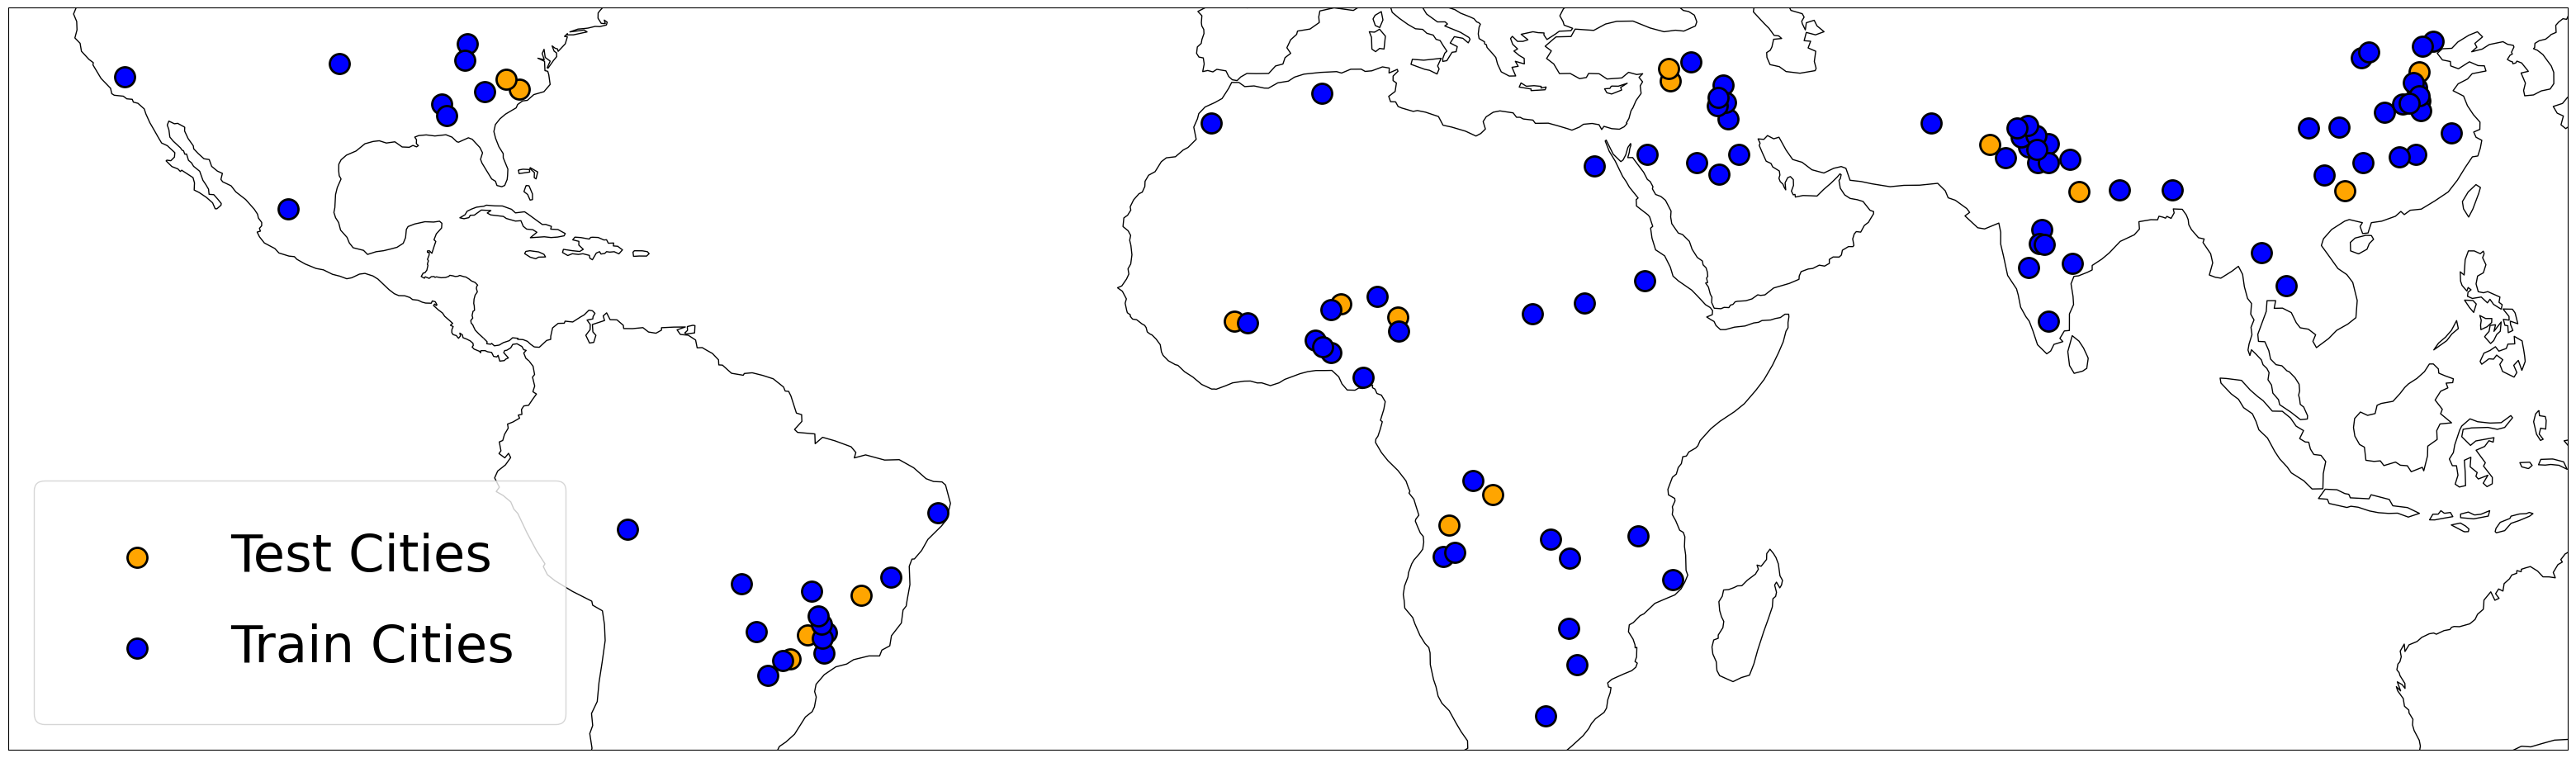

In [7]:
#create training and test datasets
#create a list of the candiates
test_candidates = CITY_COUNTRY_lat_lon.copy()
#get one letter koppen geiger
koppen_1_list = []
for i in range(len(test_candidates)):
    koppen_1_letter = test_candidates.koppen_climate[i][0]
    koppen_1_list.append(koppen_1_letter)
    
test_candidates['koppen_1_letter'] = koppen_1_list

#randomly pick test cities from each group

#9 cities to be chosen
#5 from A, 7 from B, 6 from C
num_A = len(test_candidates[test_candidates['koppen_1_letter'] == 'A'])
num_B = len(test_candidates[test_candidates['koppen_1_letter'] == 'B'])
num_C = len(test_candidates[test_candidates['koppen_1_letter'] == 'C'])
num_D = len(test_candidates[test_candidates['koppen_1_letter'] == 'D'])

# generate random test cities
test_cities = random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'A'].City.values)], k=5)
test_cities = test_cities + (random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'B'].City.values)],
                                           k=5))
test_cities = test_cities + (random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'C'].City.values)],
                                           k=6))


#create the datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

#get the groups
groups_train = training_data.City
groups_test = test_data.City
    
print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

# get polynomail terms and interactions
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
X_train_poly = X_train_poly.drop('1', axis=1)

X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
X_test_poly = X_test_poly.drop('1', axis=1)

#Create a plot of train and test cities and save
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))

test_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
test_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

train_lats = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
train_lons = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(test_lons, test_lats, zorder=5,color='orange', label='Test Cities', linewidths = 2, s =300,edgecolor = 'black')
ax.scatter(train_lons, train_lats, zorder=5,color='blue', label='Train Cities', linewidths = 2, s =300,edgecolor = 'black')

ax.legend(loc=3, borderpad = 1, fontsize = 45, labelspacing=0.8)

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling','RR_pruning'))   
plt.savefig('train_test_map_{}.png'.format(prune_name), bbox_inches = 'tight')

In [8]:
# Create the dataframe to be filled
prune_df = pd.DataFrame(columns = ['Prune', 'Number_Variables','Train_r2', 'Test_r2', 'Train_RMSE', 'Test_RMSE', 'Alpha', 
                        'Varible_Names'])
prune_num = 0

#start with all the variables
Predictor_Variables_pruned = list(X_train_poly.columns)

while len(Predictor_Variables_pruned) > 0:
    
    #enter the variables which are going into this model
    prune_df.loc[prune_num, 'Varible_Names'] = list(Predictor_Variables_pruned)
    
    # prune
    X_train_poly = X_train_poly[Predictor_Variables_pruned]
    X_test_poly = X_test_poly[Predictor_Variables_pruned]

    #create normalised datasets
    #the test dataset is normalised using the normalisation parameters from the training data
    scaler = StandardScaler()
    X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
    X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

    X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
    X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

    y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
    y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
    ##########################
    #### RIDGE REGRESSION ####
    ##########################

    folds = 5    #define the number of folds (K)

    #define regression model
    ridge_reg = Ridge(fit_intercept=True)
    #specify the hyperparameters to test
    hyper_params = {'alpha':[0,1,50,90,150, 900,1100, 5000, 20000]}

    hyper_params_0_100 = [0,1e-10,1,10,20,30,40,50,60,70,80,90,100, 130]
    hyper_params_100_1000 = [90,100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,700, 750, 800, 850, 900, 950, 1000]
    hyper_params_1000_10000 = [900,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 100000]
    hyper_params_10000_100000 = [9000,10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 1000000]
    
    #use cross validation to determine the hyperparameter value
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    if chosen_alpha <=100:
        hyper_params_choice = hyper_params_0_100
    elif chosen_alpha <=1000:
        hyper_params_choice = hyper_params_100_1000
    elif chosen_alpha <=10000:
        hyper_params_choice = hyper_params_1000_10000
    elif chosen_alpha <=100000:
        hyper_params_choice = hyper_params_10000_100000
    
    hyper_params = {'alpha':hyper_params_choice}
    #use cross validation to determine the hyperparameter value to higher precision
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    
    RR_model = Ridge(alpha=chosen_alpha)
    RR_model.fit(X_train_poly_norm, y_train)

    d = {'Predictor_Variable': X_train_poly_norm.columns, 'Coefficients': RR_model.coef_}
    coeff_df = pd.DataFrame(data=d)

    coeff_df['Coefficient_Magnitude'] = abs(coeff_df.Coefficients)
    coeff_df = coeff_df.sort_values(by = 'Coefficient_Magnitude', ascending=False).reset_index(drop = True)
    
    # Generate the performance stats
    y_train_pred = RR_model.predict(X_train_poly_norm)
    y_test_pred = RR_model.predict(X_test_poly_norm)

    #####################################################
    ###### Performance Metrics for the training set ######
    ######################################################
    #rmse
    train_ridge_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    #r-square~
    train_ridge_r2 = r2_score(y_train, y_train_pred)
    #mae
    train_ridge_mae = mean_absolute_error(y_train, y_train_pred)

    #################################################
    ###### Performance Metrics for the test set #####
    #################################################
    #rmse
    test_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #r-square
    test_ridge_r2 = r2_score(y_test, y_test_pred)
    #mae
    test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
                            
                            
    # Decide which variables to remove based on their coefficients. Once coefficents are higher, just removed the smallest
    current_num_vars = len(Predictor_Variables_pruned)
    
    
    #start by removing variables with a coefficient of less than 0.05
    min_coefficient = 0.05
       
    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                        
    new_num_vars = len(Predictor_Variables_pruned) 
    
    if new_num_vars == current_num_vars:
        min_coefficient = 0.1
        Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values
        new_num_vars = len(Predictor_Variables_pruned)
    
    if new_num_vars == current_num_vars:
        min_coefficient = 0.2
        Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                       
        new_num_vars = len(Predictor_Variables_pruned)
    
    if new_num_vars == current_num_vars:                    
        min_coefficient = min(coeff_df.Coefficient_Magnitude)
        Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                    
        new_num_vars = len(Predictor_Variables_pruned)
    
    #add the results to the dataframe 
    prune_df.loc[prune_num, 'Prune'] = prune_num
    prune_df.loc[prune_num, 'Number_Variables'] = current_num_vars                       
    prune_df.loc[prune_num, 'Train_r2'] = train_ridge_r2                       
    prune_df.loc[prune_num, 'Test_r2'] = test_ridge_r2
    prune_df.loc[prune_num, 'Train_RMSE'] = train_ridge_rmse
    prune_df.loc[prune_num, 'Test_RMSE'] = test_ridge_rmse
    prune_df.loc[prune_num, 'Alpha'] = chosen_alpha
                         
    #add to the prune count
    prune_num = prune_num + 1                        

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.51185e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.42937e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.41536e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 

In [16]:
prune_df[prune_df.Number_Variables == 6].Varible_Names.values

array([list(['EVI_R sqrt_SSR', 'SSR EVI_D', 'SSR EVI_R', 'EVI_U EVI_D', 'LOG_AREA ROUGHNESS_LENGTH_R', 'EF LOG_AREA'])],
      dtype=object)

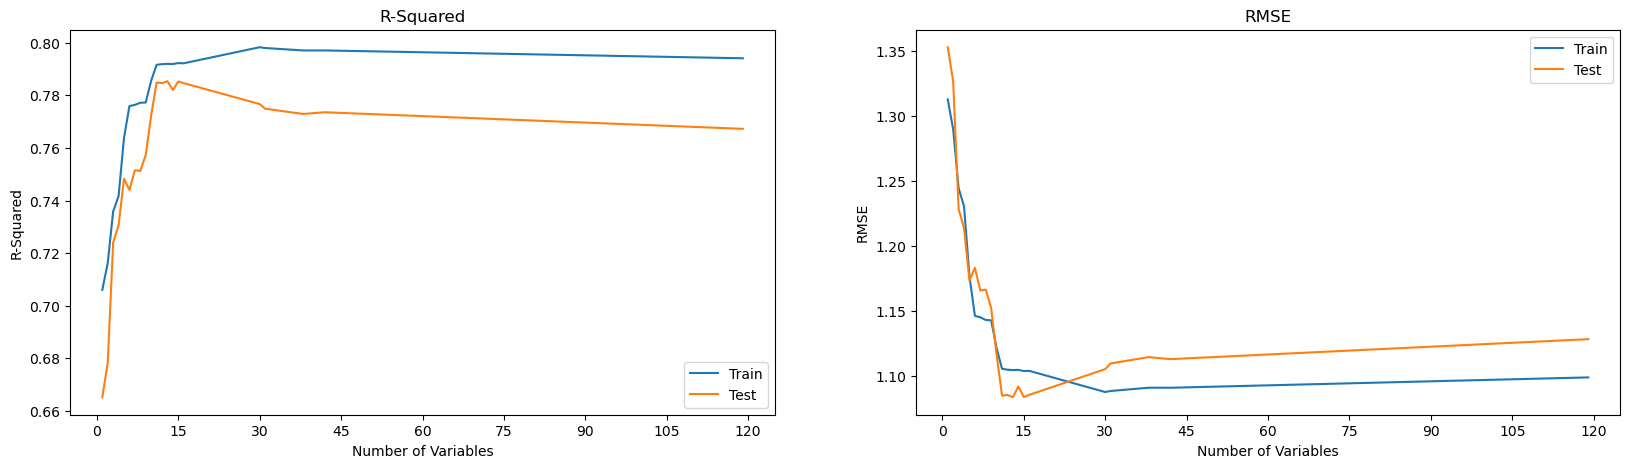

In [10]:
#plot the number of variables against the r-squared and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(prune_df.Number_Variables, prune_df.Train_r2, label = 'Train')
axes[0].plot(prune_df.Number_Variables, prune_df.Test_r2, label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(prune_df.Number_Variables, prune_df.Train_RMSE, label = 'Train')
axes[1].plot(prune_df.Number_Variables, prune_df.Test_RMSE, label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [95]:
prune_df[prune_df.Number_Variables == 2].Varible_Names.values

array([list(['SSR EVI_D', 'sqrt_EVI_R_p1 sqrt_EVI_D_p1'])], dtype=object)

In [138]:
############################################
##############PRUNE ENSEMBLES ##############
############################################

# create empty df for all the ensembles to be stored
all_prunes = pd.DataFrame()

for test_num in range(1,100):

    #create training and test datasets
    #create a list of the candiates
    test_candidates = CITY_COUNTRY_lat_lon.copy()
    #get one letter koppen geiger
    koppen_1_list = []
    for i in range(len(test_candidates)):
        koppen_1_letter = test_candidates.koppen_climate[i][0]
        koppen_1_list.append(koppen_1_letter)
    
    test_candidates['koppen_1_letter'] = koppen_1_list

    #randomly pick test cities from each group

    #9 cities to be chosen
    #5 from A, 7 from B, 6 from C
    num_A = len(test_candidates[test_candidates['koppen_1_letter'] == 'A'])
    num_B = len(test_candidates[test_candidates['koppen_1_letter'] == 'B'])
    num_C = len(test_candidates[test_candidates['koppen_1_letter'] == 'C'])
    num_D = len(test_candidates[test_candidates['koppen_1_letter'] == 'D'])

    # generate random test cities
    test_cities = random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'A'].City.values)], k=5)
    test_cities = test_cities + (random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'B'].City.values)],
                                           k=5))
    test_cities = test_cities + (random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'C'].City.values)],
                                           k=6))


    #create the datasets
    training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
    test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    #get the groups
    groups_train = training_data.City
    groups_test = test_data.City
    
    #split the data into training and test
    X_train = training_data[predictor_variables]  #predictors
    y_train = training_data[target_variable]      #target

    X_test = test_data[predictor_variables]       #predictors
    y_test = test_data[target_variable]           #target

    # get polynomail terms and interactions
    poly = PolynomialFeatures(2)
    X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
    X_train_poly = X_train_poly.drop('1', axis=1)

    X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
    X_test_poly = X_test_poly.drop('1', axis=1)


    # Create the dataframe to be filled
    prune_df = pd.DataFrame(columns = ['Test_Num','Prune', 'Number_Variables','Train_r2', 'Test_r2', 'Train_RMSE',
                                       'Test_RMSE', 'Alpha' ])
    
    prune_df['Test_Num'] = test_num
    prune_num = 0

    #start with all the variables
    Predictor_Variables_pruned = list(X_train_poly.columns)

    while len(Predictor_Variables_pruned) > 0:
    
        #enter the variables which are going into this model
        #prune_df.loc[prune_num, 'Varible_Names'] = list(Predictor_Variables_pruned)
    
        # prune
        X_train_poly = X_train_poly[Predictor_Variables_pruned]
        X_test_poly = X_test_poly[Predictor_Variables_pruned]

        #create normalised datasets
        #the test dataset is normalised using the normalisation parameters from the training data
        scaler = StandardScaler()
        X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
        X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

        X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
        X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

        y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
        y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
        ##########################
        #### RIDGE REGRESSION ####
        ##########################

        folds = 5    #define the number of folds (K)

        #define regression model
        ridge_reg = Ridge(fit_intercept=True)
        #specify the hyperparameters to test
        hyper_params = {'alpha':[0,1,50,90,150, 900,1100, 5000, 20000]}

        hyper_params_0_100 = [0,1e-10,1,10,20,30,40,50,60,70,80,90,100, 130]
        hyper_params_100_1000 = [90,100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,700, 750, 800, 850, 900, 950, 1000]
        hyper_params_1000_10000 = [900,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 100000]
        hyper_params_10000_100000 = [9000,10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 1000000]
    
        #use cross validation to determine the hyperparameter value
        model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
        #fit the model
        model_cv.fit(X_train_poly_norm, y_train)  
    
        chosen_alpha = list(model_cv.best_params_.values())[0]
        if chosen_alpha <=100:
            hyper_params_choice = hyper_params_0_100
        elif chosen_alpha <=1000:
            hyper_params_choice = hyper_params_100_1000
        elif chosen_alpha <=10000:
            hyper_params_choice = hyper_params_1000_10000
        elif chosen_alpha <=100000:
            hyper_params_choice = hyper_params_10000_100000
    
        hyper_params = {'alpha':hyper_params_choice}
        #use cross validation to determine the hyperparameter value to higher precision
        model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
        #fit the model
        model_cv.fit(X_train_poly_norm, y_train)  
    
        chosen_alpha = list(model_cv.best_params_.values())[0]
    
        RR_model = Ridge(alpha=chosen_alpha)
        RR_model.fit(X_train_poly_norm, y_train)

        d = {'Predictor_Variable': X_train_poly_norm.columns, 'Coefficients': RR_model.coef_}
        coeff_df = pd.DataFrame(data=d)

        coeff_df['Coefficient_Magnitude'] = abs(coeff_df.Coefficients)
        coeff_df = coeff_df.sort_values(by = 'Coefficient_Magnitude', ascending=False).reset_index(drop = True)
    
        # Generate the performance stats
        y_train_pred = RR_model.predict(X_train_poly_norm)
        y_test_pred = RR_model.predict(X_test_poly_norm)

        #####################################################
        ###### Performance Metrics for the training set ######
        ######################################################
        #rmse
        train_ridge_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        #r-square~
        train_ridge_r2 = r2_score(y_train, y_train_pred)

        #################################################
        ###### Performance Metrics for the test set #####
        #################################################
        #rmse
        test_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        #r-square
        test_ridge_r2 = r2_score(y_test, y_test_pred)                       
                            
        # Decide which variables to remove based on their coefficients. Once coefficents are higher, just removed the smallest
        current_num_vars = len(Predictor_Variables_pruned)
    
        #start by removing variables with a coefficient of less than 0.05
        min_coefficient = 0.05
       
        Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                        
        new_num_vars = len(Predictor_Variables_pruned) 
    
        if new_num_vars == current_num_vars:
            min_coefficient = 0.1
            Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values
            new_num_vars = len(Predictor_Variables_pruned)
    
        if new_num_vars == current_num_vars:
            min_coefficient = 0.2
            Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                       
            new_num_vars = len(Predictor_Variables_pruned)
    
        if new_num_vars == current_num_vars:                    
            min_coefficient = min(coeff_df.Coefficient_Magnitude)
            Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                    
            new_num_vars = len(Predictor_Variables_pruned)
    
        #add the results to the dataframe 
        prune_df.loc[prune_num, 'Prune'] = prune_num
        prune_df.loc[prune_num, 'Number_Variables'] = current_num_vars                       
        prune_df.loc[prune_num, 'Train_r2'] = float(train_ridge_r2)                    
        prune_df.loc[prune_num, 'Test_r2'] = float(test_ridge_r2)
        prune_df.loc[prune_num, 'Train_RMSE'] = float(train_ridge_rmse)
        prune_df.loc[prune_num, 'Test_RMSE'] = float(test_ridge_rmse)
        prune_df.loc[prune_num, 'Alpha'] = float(chosen_alpha)
        prune_df['Test_Num'] = test_num                 
        #add to the prune count
        prune_num = prune_num + 1  

    all_prunes = pd.concat([all_prunes, prune_df])
    
all_prunes['Train_r2'] = all_prunes['Train_r2'].apply(lambda x: float(x))
all_prunes['Test_r2'] = all_prunes['Test_r2'].apply(lambda x: float(x))
all_prunes['Train_RMSE'] = all_prunes['Train_RMSE'].apply(lambda x: float(x))
all_prunes['Test_RMSE'] = all_prunes['Test_RMSE'].apply(lambda x: float(x))
all_prunes['Alpha'] = all_prunes['Alpha'].apply(lambda x: float(x))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 c

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.1113e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.67767e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.70059e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 1

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.91523e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.91523e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.34583e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.34583e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.14152e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.99262e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.08337e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.14152e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.99262e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.08337e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.90764e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.9842e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.18285e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.90764e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.9842e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.18285e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.12101e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.22904e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.82972e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.13807e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.12101e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.22904e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.82972e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.13807e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.75262e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.36045e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.31184e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.25868e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.75262e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.36045e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.31184e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.25868e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.14037e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.05031e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.37138e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.0999e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.14037e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.05031e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.37138e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.0999e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.80434e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.64926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.31068e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.80434e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.64926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.31068e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.75849e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.27883e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.02769e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.6926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.75849e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.27883e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.02769e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.6926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.93474e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.06615e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.0489e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.93773e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.93474e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.06615e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.0489e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.93773e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.86601e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.59366e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.33961e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.4345e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.51019e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.23365e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.09501e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.19283e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.85073e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5826e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.09547e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5826e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.09547e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 ca

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.58537e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.95089e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.11412e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.3101e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.07979e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.1852e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.70463e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.21385e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.60445e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.50053e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.04273e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.1916e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.06613e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.98312e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.84432e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.73504e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.43154e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.43186e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.23198e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 c

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.96801e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.56825e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.4118e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.45894e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.78546e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.00869e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.26155e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.0164e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.0164e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.88102e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.88102e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.98996e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.98996e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.81182e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.81182e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.1811e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.1811e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.2404e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.2404e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.47586e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.18697e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.37304e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.47586e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.37304e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.37304e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 c

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.91305e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.3765e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.24552e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.44662e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.36897e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.28073e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.18584e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.68572e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.07754e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.67234e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5104e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.15732e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 1

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.77701e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.9064e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.116e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.34579e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.01753e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.66602e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.34336e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.64645e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 2

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.51329e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.71845e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.99067e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.27014e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.51329e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.71845e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.99067e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.27014e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.70315e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.23365e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.36216e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.64194e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.70315e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.23365e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.36216e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.64194e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.4835e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.28288e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.39495e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.4835e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.28288e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.39495e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.91754e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.78432e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11404e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.91754e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.78432e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11404e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.34884e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.22311e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.47189e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.34884e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.22311e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.47189e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.95284e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.39905e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.70218e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.95284e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.39905e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.70218e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.93444e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.18776e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.93444e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.18776e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.42768e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.57065e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11078e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.42768e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.57065e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11078e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.63771e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.92856e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.63771e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.92856e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.26073e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.65664e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.12499e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.85083e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.13329e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.14534e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.00083e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.10078e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.58013e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.38478e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.26504e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.47269e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.52095e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.42331e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.48944e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.07627e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.4435e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.55207e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.4337e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.14353e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.00476e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.22537e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.20941e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.11653e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.42136e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.14875e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.48102e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.074e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.96995e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.15681e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.48669e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.22717e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.5862e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.26087e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.5862e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.26087e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.08481e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.08481e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.2066e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.86633e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.12181e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.66521e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.26898e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.7062e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.66521e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.26898e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.7062e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 ca

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.11923e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.12126e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.53874e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.51689e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.19441e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.31512e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.9221e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.09614e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.12779e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.23477e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.23477e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.40095e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.90406e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.44452e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.08261e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.40095e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.90406e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.44452e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.08261e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.10079e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.22544e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.27605e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.81064e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.81064e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.81064e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.40526e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.41879e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.74926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.40526e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.41879e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.74926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.74926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.56328e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.78207e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.07609e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.56328e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.78207e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.07609e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.07609e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.77196e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.27446e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5145e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.77196e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.27446e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5145e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5145e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.33462e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.461e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Lap

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.41782e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.33462e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.461e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.40751e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.41782e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.41782e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.40062e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.72717e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.80093e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.40062e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.72717e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.80093e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.80093e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.71874e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.4788e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.71874e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.4788e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.27629e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.62992e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.27629e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.62992e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.77833e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.86264e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.1287e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.83073e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.08838e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.91076e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.91076e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.56319e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.0332e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.56319e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.0332e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.68872e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.50736e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11063e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.68872e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.50736e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11063e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.82792e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.64104e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.82792e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.64104e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.81309e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.70579e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.81309e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.70579e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.9291e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.73472e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.9291e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.73472e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 ca

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.57917e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.23599e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.15328e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.11439e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.72386e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.14041e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.50161e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.42873e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.52468e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.7282e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.83682e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.7282e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.83682e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.60631e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.11941e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.09145e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.13682e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.23662e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.10867e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.09605e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.35847e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.58209e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.13392e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.16917e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.16809e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.40224e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.62953e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.60672e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11304e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.43821e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.43821e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.81653e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.81653e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.50047e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.9136e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.50047e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.9136e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.33312e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.23145e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.01986e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.15668e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.49595e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.33589e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5858e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.49595e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.30716e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.55551e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.43186e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.35146e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.35146e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.35146e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.89731e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.32936e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.96556e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.89731e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.32936e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.13619e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.94717e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.13619e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.94717e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.44332e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.44332e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.71999e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.32419e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.16737e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.2732e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.71999e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.32419e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.16737e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.2732e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.57333e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.75536e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.31593e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.57333e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.75536e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.31593e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 ca

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.89209e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.39332e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.37743e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.17363e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.42267e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.21749e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.05371e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.15202e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.21611e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.74929e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.77146e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.91266e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.32749e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.66693e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.24532e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.96394e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.54361e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.54971e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.73279e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.54361e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.54971e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.73279e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.10905e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.17173e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.50508e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.48268e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.39059e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.55755e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.02503e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.70438e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.72919e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.03071e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.99167e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.09289e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.28975e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.89745e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.97126e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.68009e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.45383e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.89825e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.3046e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.01205e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.00789e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.71579e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.60849e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.14024e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.27305e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.8547e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.36119e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.59358e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.74746e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.14031e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.67415e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.7966e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.89569e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.39281e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.86571e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.30523e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 2

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.2414e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.86174e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.2414e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.86174e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.25186e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.27567e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.46149e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.05304e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.25186e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.27567e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.46149e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.05304e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.16261e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.55092e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.42945e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.16261e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.55092e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.42945e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.95504e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.531e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.87242e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.95504e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.531e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.87242e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.63732e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.26662e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.30255e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.01292e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.63732e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.26662e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.30255e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.01292e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.66551e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.37195e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.33223e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.0279e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.66551e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.37195e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.33223e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.0279e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.77677e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.81418e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.50311e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.09809e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.77677e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.81418e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.50311e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.09809e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.79915e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.91781e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.54052e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.10985e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.79915e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.91781e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.54052e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.10985e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 ca

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.6698e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.6698e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.72827e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.72827e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.53337e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.53337e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.48487e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.31416e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.1204e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.44248e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.51054e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.44248e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.51054e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.69748e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.41113e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 1

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.41888e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.90237e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.36469e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.08133e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.85792e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.98432e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.45293e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.13334e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.27482e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.06315e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.03934e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.03934e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.46541e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.01634e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.46541e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.01634e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.791e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.98177e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.61262e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.85869e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.10926e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.6371e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.85869e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.10926e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.6371e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.03523e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.03523e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.93952e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.71924e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.93952e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.71924e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.77499e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.43821e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.77499e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.43821e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.67558e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.41039e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.30704e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.02805e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.67558e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.41039e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.30704e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.02805e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.36962e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.29915e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.36962e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.29915e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.2728e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.33236e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.29969e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.2728e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.33236e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.29969e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 ca

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.08466e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.08217e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.08952e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.68907e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.14074e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.23957e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.28217e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.72915e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.26242e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.11404e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.79247e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.0787e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.61423e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.46819e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.04312e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.76921e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.22851e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.55871e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.93487e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 2

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.80044e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.80044e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.73833e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.73833e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.56191e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.56191e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.70771e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.81403e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.40212e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.70771e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.81403e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.40212e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.24803e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.17752e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.24803e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.17752e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.29443e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.31631e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.29443e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.31631e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.37265e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.33764e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.37265e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.33764e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.71603e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.68961e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.16563e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.71603e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.68961e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.16563e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.29861e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.30889e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.99867e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.29861e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.30889e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.99867e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.02469e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.02469e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.61596e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.61596e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.30422e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.44356e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.36885e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.30422e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.44356e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.36885e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.13075e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.67041e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.94485e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.21683e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.90934e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.98127e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.90934e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.98127e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.93198e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.27809e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.31498e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.82205e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.26687e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.11398e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.79233e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.1974e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.55545e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.43898e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.73163e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.44026e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.16716e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.56835e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.50705e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.34793e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.49453e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.78226e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.10324e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.04715e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.53709e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.13319e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.2926e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.3037e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.57118e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.27776e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.9408e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.39533e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.11712e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.76693e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.97542e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.54712e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.91864e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.05872e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.93133e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.52249e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.62452e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.93133e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.52249e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.62452e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.44831e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.47705e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.13553e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.34632e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.44831e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.47705e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.13553e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.34632e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.52966e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.68633e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.20056e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.86119e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.52966e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.68633e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.20056e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.86119e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.39091e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.38355e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.91262e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.32209e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.39091e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.38355e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.91262e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.32209e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.83043e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.0507e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.57179e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.80103e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.83043e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.0507e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.57179e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.80103e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.07439e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.28397e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.33256e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.07439e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.28397e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.33256e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.87962e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.00957e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.85728e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.87962e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.00957e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.85728e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.03628e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.87219e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.94232e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.03628e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.87219e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.94232e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.72395e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.32729e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.96708e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.87982e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.72395e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.32729e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.96708e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.87982e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.02911e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.20423e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.98138e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.55001e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.02911e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.20423e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.98138e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.55001e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.97045e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.07593e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.79559e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.56945e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.97045e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.07593e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.79559e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.56945e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.05072e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.77306e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.57313e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.67834e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.05072e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.77306e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.57313e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.67834e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.895e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.94358e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.91396e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.87616e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.895e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.94358e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.91396e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.87616e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.4679e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.08982e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.63688e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.98422e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.4679e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.08982e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.63688e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.98422e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 ca

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.04882e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.43803e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.99087e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.04882e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.43803e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.99087e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.82576e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.1666e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.82576e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.1666e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.48028e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.10757e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.48028e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.10757e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.50504e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.22124e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.50504e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.22124e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.56931e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.37919e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.56931e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.37919e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.56514e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.89681e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.56514e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.89681e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.59122e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.85744e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.76483e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.79639e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.96789e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 11 

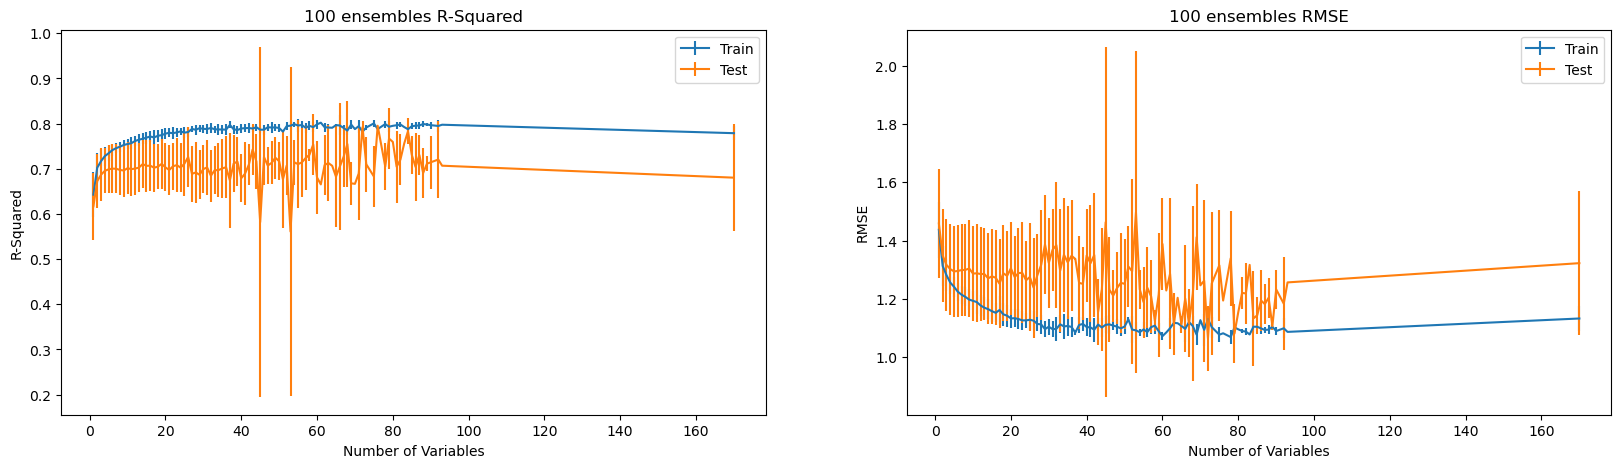

In [152]:
##############################
### Get the ensemble means ###
##############################
ensemble_means = all_prunes.groupby(['Number_Variables']).mean(numeric_only = True).reset_index()
ensemble_stds = all_prunes.groupby(['Number_Variables']).std(numeric_only = True).reset_index()

#plot the number of variables against the r-squared and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].errorbar(ensemble_means.Number_Variables, ensemble_means.Train_r2, yerr =ensemble_stds.Train_r2 ,label = 'Train')
axes[0].errorbar(ensemble_means.Number_Variables, ensemble_means.Test_r2, yerr =ensemble_stds.Test_r2 , label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = '100 ensembles R-Squared')
axes[0].legend()

axes[1].errorbar(ensemble_means.Number_Variables, ensemble_means.Train_RMSE, yerr =ensemble_stds.Train_RMSE , label = 'Train')
axes[1].errorbar(ensemble_means.Number_Variables, ensemble_means.Test_RMSE, yerr =ensemble_stds.Test_RMSE , label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = '100 ensembles RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

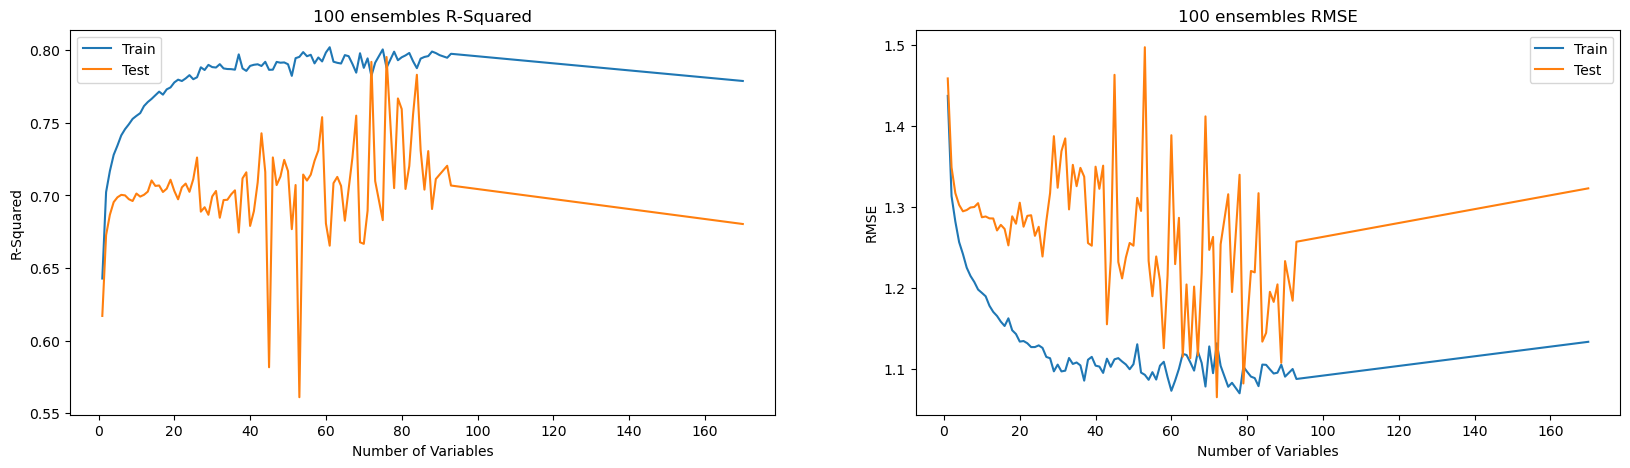

In [153]:
###### Without error bars ######

#plot the number of variables against the r-squared and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(ensemble_means.Number_Variables, ensemble_means.Train_r2 ,label = 'Train')
axes[0].plot(ensemble_means.Number_Variables, ensemble_means.Test_r2, label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = '100 ensembles R-Squared')
axes[0].legend()

axes[1].plot(ensemble_means.Number_Variables, ensemble_means.Train_RMSE , label = 'Train')
axes[1].plot(ensemble_means.Number_Variables, ensemble_means.Test_RMSE, label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = '100 ensembles RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [26]:
######################################################
##############PRUNE BASED ON 9 YR SPLIT ##############
######################################################
#create training and test datasets

#create the datasets
data_2002_2011 = all_monthly_data_df2[((all_monthly_data_df2.year <= 2011) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_2012_2020 = all_monthly_data_df2[((all_monthly_data_df2.year >= 2012)
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

training_data = data_2002_2011
test_data = data_2012_2020

#training_data = data_2012_2020
#test_data = data_2002_2011

#split the data into training and test
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

# get polynomail terms and interactions
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
X_train_poly = X_train_poly.drop('1', axis=1)

X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
X_test_poly = X_test_poly.drop('1', axis=1)


# Create the dataframe to be filled
time_split_prune_df = pd.DataFrame(columns = ['Prune', 'Number_Variables','Train_r2', 'Test_r2', 'Train_RMSE', 'Test_RMSE', 'Alpha', 
                        'Varible_Names'])
prune_num = 0

#start with all the variables
Predictor_Variables_pruned = list(X_train_poly.columns)
#Predictor_Variables_pruned.remove('GRASSLAND WATER') # rm grassland*water- fitting model with this led to poor test perf

while len(Predictor_Variables_pruned) > 0:
    
    #enter the variables which are going into this model
    time_split_prune_df.loc[prune_num, 'Varible_Names'] = list(Predictor_Variables_pruned)
    
    # prune
    X_train_poly = X_train_poly[Predictor_Variables_pruned]
    X_test_poly = X_test_poly[Predictor_Variables_pruned]

    #create normalised datasets
    #the test dataset is normalised using the normalisation parameters from the training data
    scaler = StandardScaler()
    X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
    X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

    X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
    X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

    y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
    y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
    ##########################
    #### RIDGE REGRESSION ####
    ##########################

    folds = 5    #define the number of folds (K)

    #define regression model
    ridge_reg = Ridge(fit_intercept=True)
    #specify the hyperparameters to test
    hyper_params = {'alpha':[0,1,50,90,150, 900,1100, 5000, 20000]}

    hyper_params_0_100 = [0,1e-10,1,10,20,30,40,50,60,70,80,90,100, 130]
    hyper_params_100_1000 = [90,100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,700, 750, 800, 850, 900, 950, 1000]
    hyper_params_1000_10000 = [900,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 100000]
    hyper_params_10000_100000 = [9000,10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 1000000]
    
    #use cross validation to determine the hyperparameter value
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    if chosen_alpha <=100:
        hyper_params_choice = hyper_params_0_100
    elif chosen_alpha <=1000:
        hyper_params_choice = hyper_params_100_1000
    elif chosen_alpha <=10000:
        hyper_params_choice = hyper_params_1000_10000
    elif chosen_alpha <=100000:
        hyper_params_choice = hyper_params_10000_100000
    
    hyper_params = {'alpha':hyper_params_choice}
    #use cross validation to determine the hyperparameter value to higher precision
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    
    RR_model = Ridge(alpha=chosen_alpha)
    RR_model.fit(X_train_poly_norm, y_train)

    d = {'Predictor_Variable': X_train_poly_norm.columns, 'Coefficients': RR_model.coef_}
    coeff_df = pd.DataFrame(data=d)

    coeff_df['Coefficient_Magnitude'] = abs(coeff_df.Coefficients)
    coeff_df = coeff_df.sort_values(by = 'Coefficient_Magnitude', ascending=False).reset_index(drop = True)
    
    # Generate the performance stats
    y_train_pred = RR_model.predict(X_train_poly_norm)
    y_test_pred = RR_model.predict(X_test_poly_norm)

    #####################################################
    ###### Performance Metrics for the training set ######
    ######################################################
    #rmse
    train_ridge_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    #r-square~
    train_ridge_r2 = r2_score(y_train, y_train_pred)
    #mae
    train_ridge_mae = mean_absolute_error(y_train, y_train_pred)

    #################################################
    ###### Performance Metrics for the test set #####
    #################################################
    #rmse
    test_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #r-square
    test_ridge_r2 = r2_score(y_test, y_test_pred)
    #mae
    test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
                            
                            
    # Decide which variables to remove based on their coefficients. Once coefficents are higher, just removed the smallest
    current_num_vars = len(Predictor_Variables_pruned)
    
    
    #start by removing variables with a coefficient of less than 0.05
    min_coefficient = 0.05
       
    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                        
    new_num_vars = len(Predictor_Variables_pruned) 
    
    #if new_num_vars == current_num_vars:
    #    min_coefficient = 0.1
    #    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values
    #    new_num_vars = len(Predictor_Variables_pruned)
    
    #if new_num_vars == current_num_vars:
    #    min_coefficient = 0.2
    #    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                       
    #    new_num_vars = len(Predictor_Variables_pruned)
    
    if new_num_vars == current_num_vars:                    
        min_coefficient = min(coeff_df.Coefficient_Magnitude)
        Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                    
        new_num_vars = len(Predictor_Variables_pruned)
    
    #add the results to the dataframe 
    time_split_prune_df.loc[prune_num, 'Prune'] = prune_num
    time_split_prune_df.loc[prune_num, 'Number_Variables'] = current_num_vars                       
    time_split_prune_df.loc[prune_num, 'Train_r2'] = train_ridge_r2                       
    time_split_prune_df.loc[prune_num, 'Test_r2'] = test_ridge_r2
    time_split_prune_df.loc[prune_num, 'Train_RMSE'] = train_ridge_rmse
    time_split_prune_df.loc[prune_num, 'Test_RMSE'] = test_ridge_rmse
    time_split_prune_df.loc[prune_num, 'Alpha'] = chosen_alpha
                         
    #add to the prune count
    prune_num = prune_num + 1                        
    
time_split_prune_df['Train_r2'] = time_split_prune_df['Train_r2'].apply(lambda x: float(x))
time_split_prune_df['Test_r2'] = time_split_prune_df['Test_r2'].apply(lambda x: float(x))
time_split_prune_df['Train_RMSE'] = time_split_prune_df['Train_RMSE'].apply(lambda x: float(x))
time_split_prune_df['Test_RMSE'] = time_split_prune_df['Test_RMSE'].apply(lambda x: float(x))
time_split_prune_df['Alpha'] = time_split_prune_df['Alpha'].apply(lambda x: float(x))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.09645e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.39572e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.84828e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.13902e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.05154e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.79795e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.0177e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.08427e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.02601e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.53818e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.60671e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each o

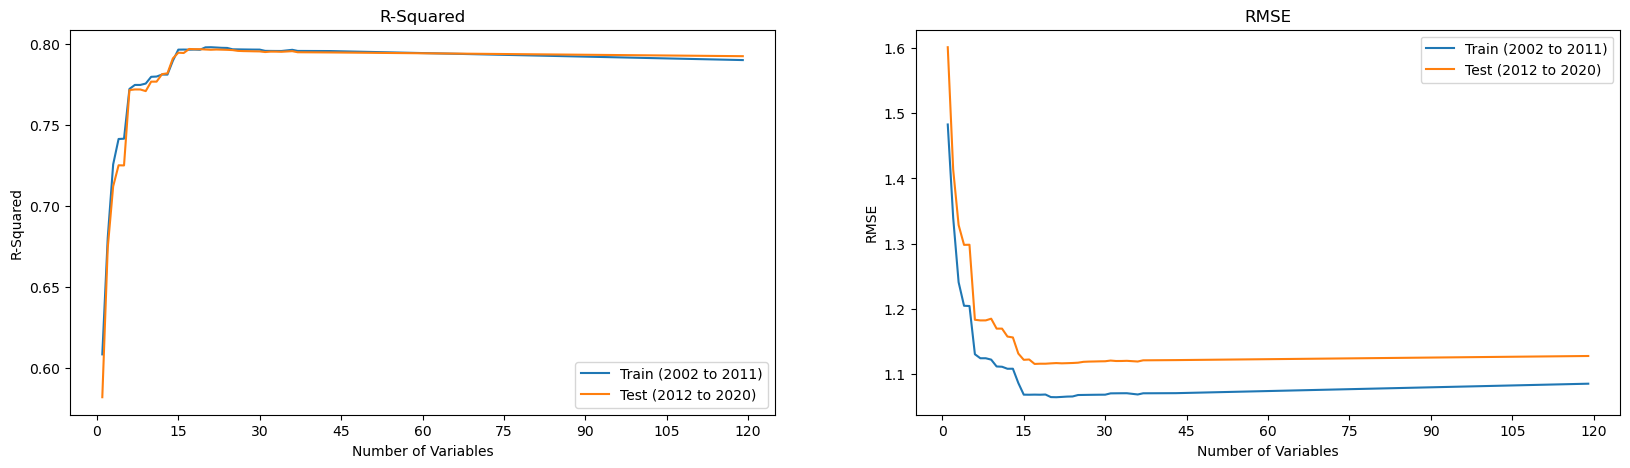

In [27]:
#plot the number of variables against the r-squared and rmse
time_split_prune_df_test_2012_2020 = time_split_prune_df.copy()

train_years = '2002 to 2011'
test_years = '2012 to 2020'

fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_r2, label = 'Train ({})'.format(train_years))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_r2, label = 'Test ({})'.format(test_years))
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_RMSE, label = 'Train ({})'.format(train_years))
axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_RMSE, label = 'Test ({})'.format(test_years))
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

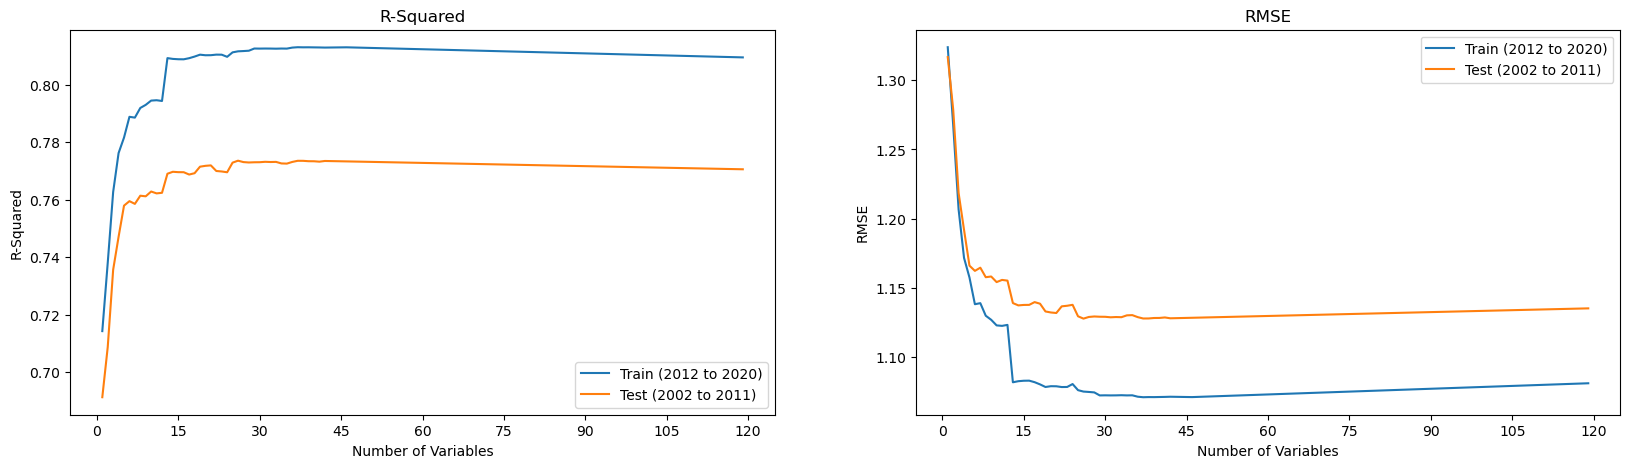

In [25]:
#plot the number of variables against the r-squared and rmse
time_split_prune_df_test_2002_2011 = time_split_prune_df.copy()

train_years = '2012 to 2020'
test_years = '2002 to 2011'

fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_r2, label = 'Train ({})'.format(train_years))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_r2, label = 'Test ({})'.format(test_years))
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_RMSE, label = 'Train ({})'.format(train_years))
axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_RMSE, label = 'Test ({})'.format(test_years))
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [32]:
time_split_prune_df_test_2002_2011[time_split_prune_df_test_2002_2011['Number_Variables'] >40]

,Prune,Number_Variables,Train_r2,Test_r2,Train_RMSE,Test_RMSE,Alpha,Varible_Names
0,0,119,0.809560,0.770610,1.080854,1.135034,450.0,"[EF, SSR, EVI_U, EVI_R, EVI_D, ECC, LOG_AREA, ..."
1,1,46,0.813068,0.773353,1.070853,1.128227,150.0,"[SSR EVI_D, SSR EVI_R, EVI_D sqrt_SSR, LOG_ARE..."
2,2,42,0.812977,0.773500,1.071115,1.127860,150.0,"[SSR EVI_D, SSR EVI_R, LOG_AREA ROUGHNESS_LENG..."
3,3,41,0.813020,0.773259,1.070992,1.128461,150.0,"[SSR EVI_D, SSR EVI_R, LOG_AREA ROUGHNESS_LENG..."


In [43]:
X_train_poly_norm

,SSR EVI_D,SSR EVI_R,EVI_D sqrt_SSR,LOG_AREA ROUGHNESS_LENGTH_R,EVI_U ROUGHNESS_LENGTH_R,EVI_R sqrt_SSR,EVI_D LOG_AREA,SSR EVI_U,SSR ECC,ECC sqrt_SSR,...,EVI_R,EVI_U^2,EVI_R LOG_AREA,SSR cube_EVI_D,cube_EVI_D^2,LOG_AREA sqrt_EVI_R_p1,LOG_AREA cube_EVI_D,EVI_U EVI_D,EF EVI_R,sqrt_EF ROUGHNESS_LENGTH_R
0,-2.844391,2.103058,-2.648002,-0.163995,0.056395,1.994837,-2.541028,1.184742,1.406889,1.456932,...,1.762150,0.689715,1.727760,-3.286176,1.273844,0.889756,-3.041419,-2.555524,1.669823,0.013276
1,-2.802043,1.990625,-2.589624,-0.163736,-0.006637,1.862096,-2.468441,1.053122,1.448570,1.482254,...,1.615056,0.504562,1.595290,-3.095905,1.105600,0.855578,-2.831734,-2.307917,1.561322,0.013655
2,-1.737596,1.272717,-1.729868,-0.163477,-0.017313,1.321695,-1.802030,0.706868,0.983983,1.192590,...,1.280750,0.474180,1.293231,-1.238089,0.196154,0.775597,-1.294738,-1.666887,1.386401,0.033021
3,-1.449905,0.873584,-1.606873,-0.163219,-0.047747,1.088507,-1.859273,0.325102,0.516786,0.882837,...,1.253234,0.389125,1.268926,-1.125072,0.240804,0.769950,-1.401154,-1.648723,1.206043,-0.008491
4,-0.999724,0.456809,-1.170425,-0.162961,-0.155864,0.671342,-1.440575,0.019674,0.370592,0.781506,...,0.862304,0.105597,0.915377,-0.503252,-0.001412,0.674458,-0.712540,-1.062502,0.674105,-0.085610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551,-1.026626,2.493153,-0.883123,1.740685,2.554242,2.336531,-1.238434,2.864123,-0.670891,-1.106163,...,2.042559,3.008511,2.840455,-0.105731,-0.127837,2.224852,-0.158007,-1.774705,2.200536,1.488187
6552,-0.549418,2.687325,-0.395648,1.740685,2.795660,2.420346,-0.626836,3.433935,-0.561010,-1.040894,...,2.019523,3.565761,2.814801,0.200978,-0.150316,2.218155,0.198264,-1.170879,1.821042,1.336336
6553,-0.089494,0.790173,-0.165221,1.740685,1.960890,1.055688,-0.627872,1.054547,-1.232776,-1.469696,...,1.286933,1.788119,1.998932,0.262617,-0.150301,2.001620,0.197840,-0.733653,1.598457,1.499352
6554,0.168320,0.205722,0.054698,1.740685,1.614337,0.537795,-0.421442,0.393805,-1.433135,-1.614663,...,0.903311,1.173456,1.571701,0.323825,-0.152479,1.885326,0.272258,-0.367467,1.240570,1.477796


In [65]:
set(all_monthly_data_df2.City)

{'Akola',
 'Al Obeid (Al Ubayyid)',
 'Al-Raqqa',
 'Alwar',
 'Anapolis',
 'Anshun',
 'Asyut',
 'Baaqoobah',
 'Bahawalpur',
 'Bathinda',
 'Batman',
 'Bijapur',
 'Bikaner',
 'Birmingham',
 'Birnin Kebbi',
 'Bloemfontein',
 'Bobo_Dioulasso',
 'Bozhou',
 'Bulawayo',
 'Buraydah',
 'Campo_Grande',
 'Caruaru',
 'Cascavel',
 'Cuiaba',
 'Cuito',
 'Dayton',
 'Dazhou',
 'Dengzhou',
 'Deyang',
 'Diwaniyah',
 'El Djelfa',
 'Erode',
 'Faloojah',
 'Fayetteville',
 'Franca',
 'Fuyang',
 'Gaoan',
 'Gaya',
 'Gombe',
 'Greenville',
 "Ha'il",
 'Hafar_al_Batin',
 'Hechi',
 'Heze',
 'Hisar',
 'Huaihua',
 'Jalandhar',
 'Kandahar',
 'Kassala',
 'Kasur',
 'Khammam',
 'Kikwit',
 'Kirkuk',
 'Lampang',
 'Lexington-Fayette',
 'Likasi',
 'Linqing',
 'Liuyang',
 'Londrina',
 'Luohe',
 'Malanje',
 'Maringa',
 'Marrakech',
 'Mathura',
 'Montes Claros',
 'Montgomery',
 'Muzaffarnagar',
 'Mymensingh',
 'Nakhon Ratchasima',
 'Nampula',
 'Nanded Waghala',
 'Ndola',
 'Ningguo',
 'Nyala',
 'Ogbomosho',
 'Parakou',
 'Parbhani

In [62]:
all_monthly_data_df2[(all_monthly_data_df2['City'] == city)]

,EF,SSR,EVI_U,EVI_R,EVI_D,ECC,LOG_AREA,sqrt_EF,sqrt_SSR,sqrt_EVI_R_p1,sqrt_EVI_U_p1,cube_EVI_D,ELEVATION_D,ROUGHNESS_LENGTH_R,SUHI_MEAN,City,Overpass,month,year


In [60]:
all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time)
                                    & (all_monthly_data_df2['year'] >= 2012))].copy()



,EF,SSR,EVI_U,EVI_R,EVI_D,ECC,LOG_AREA,sqrt_EF,sqrt_SSR,sqrt_EVI_R_p1,sqrt_EVI_U_p1,cube_EVI_D,ELEVATION_D,ROUGHNESS_LENGTH_R,SUHI_MEAN,City,Overpass,month,year


In [59]:
######################################################
########## R SQUARE PLOTS TEST 2002 to 2011 ##########
######################################################

num_vars = 46

######## RR REGRESSION #################
#fit the rr model
chosen_predictor_variables = time_split_prune_df_test_2002_2011[time_split_prune_df_test_2002_2011['Number_Variables'] ==num_vars
                                                        ].Varible_Names.values[0]
alpha_value = time_split_prune_df_test_2002_2011[time_split_prune_df_test_2002_2011['Number_Variables'] ==num_vars
                                                        ].Alpha.values[0]

predictor_variables = predictor_variables_2
training_data = data_2012_2020
test_data = data_2002_2011


#split the data into training and test
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

#X_test = test_data[predictor_variables]       #predictors
#y_test = test_data[target_variable]           #target

# get polynomail terms and interactions
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
X_train_poly = X_train_poly.drop('1', axis=1)

#X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
#X_test_poly = X_test_poly.drop('1', axis=1)

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
#scaler = StandardScaler()
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
#X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

RR_model = Ridge(alpha=alpha_value)
RR_model.fit(X_train_poly_norm, y_train)

plt.rc('legend', fontsize=10)    # legend fontsize
#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values

train_r2_list = []
train_mean_pred_diff_list = []
train_rmse_list = []
train_annual_mean_SUHI_MEAN_list = []

test_r2_list = []
test_mean_pred_diff_list = []
test_rmse_list = []
test_annual_mean_SUHI_MEAN_list = []


for i, city in enumerate(cities):
    train_data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time)
                                    & (all_monthly_data_df2['year'] >= 2012))].copy()

    
    test_data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time)
                                    & (all_monthly_data_df2['year'] <= 2011))].copy()
    
    
    X_train_data_city = train_data_city[predictor_variables]                                          #predictors
    X_test_data_city = test_data_city[predictor_variables]
    
    # get polynomail terms and interactions
    X_train_city_poly = pd.DataFrame(poly.fit_transform(X_train_data_city
                                                ), columns = poly.get_feature_names_out(X_train_data_city.columns))
    X_train_city_poly = X_train_city_poly.drop('1', axis=1)
    X_train_city_poly = X_train_city_poly[chosen_predictor_variables]
    
    X_test_city_poly = pd.DataFrame(poly.fit_transform(X_test_data_city
                                                ), columns = poly.get_feature_names_out(X_test_data_city.columns))
    X_test_city_poly = X_test_city_poly.drop('1', axis=1)
    X_test_city_poly = X_test_city_poly[chosen_predictor_variables]
    
    #create normalised datasets
    X_train_city_norm = pd.DataFrame(scaler.transform(X_train_city_poly), columns = X_train_city_poly.columns) #transform only
    X_test_city_norm = pd.DataFrame(scaler.transform(X_test_city_poly), columns = X_test_city_poly.columns) #transform only
    
    y_train_data_city = train_data_city[target_variable]                                         #target
    y_test_data_city = test_data_city[target_variable]
    
    y_train_city_pred = RR_model.predict(X_train_city_norm)
    y_test_city_pred = RR_model.predict(X_test_city_norm)
    
    #train
    train_r2_score_city = r2_score(y_train_data_city, y_train_city_pred)                         #predict the r2 score
    train_mean_pred_diff = abs(y_train_city_pred - y_train_data_city).mean()
    train_rmse_city = np.sqrt(mean_squared_error(y_train_data_city, y_train_city_pred))
    train_annual_mean_SUHI_MEAN = y_train_data_city.mean()
    
    train_r2_list.append(train_r2_score_city)
    train_mean_pred_diff_list.append(train_mean_pred_diff)
    train_rmse_list.append(train_rmse_city)
    train_annual_mean_SUHI_MEAN_list.append(train_annual_mean_SUHI_MEAN)
    
    #test
    test_r2_score_city = r2_score(y_test_data_city, y_test_city_pred)                         #predict the r2 score
    test_mean_pred_diff = abs(y_test_city_pred - y_test_data_city).mean()
    test_rmse_city = np.sqrt(mean_squared_error(y_test_data_city, y_test_city_pred))
    test_annual_mean_SUHI_MEAN = y_test_data_city.mean()
    
    test_r2_list.append(test_r2_score_city)
    test_mean_pred_diff_list.append(test_mean_pred_diff)
    test_rmse_list.append(test_rmse_city)
    test_annual_mean_SUHI_MEAN_list.append(test_annual_mean_SUHI_MEAN)
    
    # create a plot of the actual vs predicted
    fig, axes = plt.subplots(1,1, figsize = (8, 8))

    axes.scatter(y_train_data_city, y_train_city_pred, label = 'Train (2012-2020)')
    axes.scatter(y_test_data_city, y_test_city_pred, label = 'Test (2002-2011)')
    axes.set(title = '{} Ridge Reg, Test {}'.format(city, overpass_time), 
         xlabel = 'Observed Mean SUHI Magnitude (K)', ylabel = 'Predicted Mean SUHI Magnitude (K)')

    axes.legend(loc = 4)
    axesmin = min(min(y_train_data_city),min(y_test_data_city), min(y_train_city_pred),min(y_test_city_pred)) - 1
    axesmax = max(max(y_train_data_city),max(y_test_data_city), max(y_train_city_pred),max(y_test_city_pred)) + 1

    axes.set_xlim([axesmin, axesmax])
    axes.set_ylim([axesmin, axesmax])

    axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

    axes.text(0.05, 0.9, 'Train $R^2$= {}'.format(round(train_r2_score_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.85, 'Test $R^2$= {}'.format(round(test_r2_score_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.8, 'Train RMSE= {}'.format(round(train_rmse_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.75, 'Test RMSE= {}'.format(round(test_rmse_city, 2)), fontsize=15, transform=axes.transAxes)

    #save figure as png
    if overpass_time == '13:30':
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                             'Test_2002_2011','1330','Test_Train_shown'))   
        plt.savefig('{}_obvs_vs_preds_13_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    else:
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                              'Test_2002_2011','0130','Test_Train_shown'))   
        plt.savefig('{}_obvs_vs_preds_01_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    
    plt.close()
    
#create dataframe
#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    
r2_df = pd.DataFrame({'city': cities, 'train_r2':train_r2_list, 'train_mean_pred_diff':train_mean_pred_diff_list, 
                      'train_rmse':train_rmse_list, 'train_annual_mean_SUHI_MEAN':train_annual_mean_SUHI_MEAN_list
                     , 'test_r2':test_r2_list, 'test_mean_pred_diff':test_mean_pred_diff_list, 
                      'test_rmse':test_rmse_list, 'test_annual_mean_SUHI_MEAN':test_annual_mean_SUHI_MEAN_list})    
print('test_r2<0', len(r2_df[r2_df['test_r2'] < 0]))

ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by PolynomialFeatures.

In [31]:
r2_df

NameError: name 'r2_df' is not defined

In [30]:
######################################################
########## R SQUARE PLOTS TEST 2012 to 2020 ##########
######################################################

num_vars = 50

######## RR REGRESSION #################
#fit the rr model
chosen_predictor_variables = time_split_prune_df_test_2012_2020[time_split_prune_df_test_2012_2020['Number_Variables'] ==num_vars
                                                        ].Varible_Names.values[0]
alpha_value = time_split_prune_df_test_2012_2020[time_split_prune_df_test_2012_2020['Number_Variables'] ==num_vars
                                                        ].Alpha.values[0]


X_train_poly = X_train_poly[chosen_predictor_variables]
X_test_poly = X_test_poly[chosen_predictor_variables]

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

#X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
#X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

#y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
#y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
RR_model = Ridge(alpha=alpha_value)
RR_model.fit(X_train_poly_norm, y_train)

plt.rc('legend', fontsize=10)    # legend fontsize
#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values

train_r2_list = []
train_mean_pred_diff_list = []
train_rmse_list = []
train_annual_mean_SUHI_MEAN_list = []

test_r2_list = []
test_mean_pred_diff_list = []
test_rmse_list = []
test_annual_mean_SUHI_MEAN_list = []


for i, city in enumerate(cities):
    test_data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time)
                                    & (all_monthly_data_df2['year'] >= 2012))].copy()

    
    train_data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time)
                                    & (all_monthly_data_df2['year'] <= 2011))].copy()
    
    
    X_train_data_city = train_data_city[predictor_variables]                                          #predictors
    X_test_data_city = test_data_city[predictor_variables]
    
    # get polynomail terms and interactions
    X_train_city_poly = pd.DataFrame(poly.fit_transform(X_train_data_city
                                                ), columns = poly.get_feature_names_out(X_train_data_city.columns))
    X_train_city_poly = X_train_city_poly.drop('1', axis=1)
    X_train_city_poly = X_train_city_poly[chosen_predictor_variables]
    
    X_test_city_poly = pd.DataFrame(poly.fit_transform(X_test_data_city
                                                ), columns = poly.get_feature_names_out(X_test_data_city.columns))
    X_test_city_poly = X_test_city_poly.drop('1', axis=1)
    X_test_city_poly = X_test_city_poly[chosen_predictor_variables]
    
    #create normalised datasets
    X_train_city_norm = pd.DataFrame(scaler.transform(X_train_city_poly), columns = X_train_city_poly.columns) #transform only
    X_test_city_norm = pd.DataFrame(scaler.transform(X_test_city_poly), columns = X_test_city_poly.columns) #transform only
    
    y_train_data_city = train_data_city[target_variable]                                         #target
    y_test_data_city = test_data_city[target_variable]
    
    y_train_city_pred = RR_model.predict(X_train_city_norm)
    y_test_city_pred = RR_model.predict(X_test_city_norm)
    
    #train
    train_r2_score_city = r2_score(y_train_data_city, y_train_city_pred)                         #predict the r2 score
    train_mean_pred_diff = abs(y_train_city_pred - y_train_data_city).mean()
    train_rmse_city = np.sqrt(mean_squared_error(y_train_data_city, y_train_city_pred))
    train_annual_mean_SUHI_MEAN = y_train_data_city.mean()
    
    train_r2_list.append(train_r2_score_city)
    train_mean_pred_diff_list.append(train_mean_pred_diff)
    train_rmse_list.append(train_rmse_city)
    train_annual_mean_SUHI_MEAN_list.append(train_annual_mean_SUHI_MEAN)
    
    #test
    test_r2_score_city = r2_score(y_test_data_city, y_test_city_pred)                         #predict the r2 score
    test_mean_pred_diff = abs(y_test_city_pred - y_test_data_city).mean()
    test_rmse_city = np.sqrt(mean_squared_error(y_test_data_city, y_test_city_pred))
    test_annual_mean_SUHI_MEAN = y_test_data_city.mean()
    
    test_r2_list.append(test_r2_score_city)
    test_mean_pred_diff_list.append(test_mean_pred_diff)
    test_rmse_list.append(test_rmse_city)
    test_annual_mean_SUHI_MEAN_list.append(test_annual_mean_SUHI_MEAN)
    
    # create a plot of the actual vs predicted
    fig, axes = plt.subplots(1,1, figsize = (8, 8))

    axes.scatter(y_train_data_city, y_train_city_pred, label = 'Train (2002-2011)')
    axes.scatter(y_test_data_city, y_test_city_pred, label = 'Test (2012-2020)')
    axes.set(title = '{} Ridge Reg, Test {}'.format(city, overpass_time), 
         xlabel = 'Observed Mean SUHI Magnitude (K)', ylabel = 'Predicted Mean SUHI Magnitude (K)')

    axes.legend(loc = 4)
    axesmin = min(min(y_train_data_city),min(y_test_data_city), min(y_train_city_pred),min(y_test_city_pred)) - 1
    axesmax = max(max(y_train_data_city),max(y_test_data_city), max(y_train_city_pred),max(y_test_city_pred)) + 1

    axes.set_xlim([axesmin, axesmax])
    axes.set_ylim([axesmin, axesmax])

    axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

    axes.text(0.05, 0.9, 'Train $R^2$= {}'.format(round(train_r2_score_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.85, 'Test $R^2$= {}'.format(round(test_r2_score_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.8, 'Train RMSE= {}'.format(round(train_rmse_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.75, 'Test RMSE= {}'.format(round(test_rmse_city, 2)), fontsize=15, transform=axes.transAxes)

    #save figure as png
    if overpass_time == '13:30':
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                             'Test_2012_2020','1330', 'Test_Train_shown'))   
        plt.savefig('{}_obvs_vs_preds_13_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    else:
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                              'Test_2012_2020','0130', 'Test_Train_shown'))   
        plt.savefig('{}_obvs_vs_preds_01_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    
    plt.close()
    
#create dataframe
#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    
r2_df = pd.DataFrame({'city': cities, 'train_r2':train_r2_list, 'train_mean_pred_diff':train_mean_pred_diff_list, 
                      'train_rmse':train_rmse_list, 'train_annual_mean_SUHI_MEAN':train_annual_mean_SUHI_MEAN_list
                     , 'test_r2':test_r2_list, 'test_mean_pred_diff':test_mean_pred_diff_list, 
                      'test_rmse':test_rmse_list, 'test_annual_mean_SUHI_MEAN':test_annual_mean_SUHI_MEAN_list})    
print('test_r2<0', len(r2_df[r2_df['test_r2'] < 0]))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
r2_df

In [194]:
all_monthly_data_df2['EVI_D'].values.min()

-0.41510746268656706

In [199]:
bounds

array([-0.4, -0.3, -0.2, -0.2, -0.1,  0. ,  0.1,  0.2,  0.2,  0.3,  0.4])

In [202]:
######################################################
########## R SQUARE PLOTS EVI_D SHOWN ################
######################################################

#### same colorbar scale ####

num_vars = 50

test_years = 'Test_2002_2011'


######## RR REGRESSION #################
#fit the rr model
if test_years == 'Test_2002_2011':
    chosen_predictor_variables = time_split_prune_df_test_2002_2011[time_split_prune_df_test_2002_2011['Number_Variables'] ==num_vars
                                                        ].Varible_Names.values[0]
    alpha_value = time_split_prune_df_test_2002_2011[time_split_prune_df_test_2002_2011['Number_Variables'] ==num_vars
                                                        ].Alpha.values[0]
else:
    chosen_predictor_variables = time_split_prune_df_test_2012_2020[time_split_prune_df_test_2012_2020['Number_Variables'] ==num_vars
                                                        ].Varible_Names.values[0]
    alpha_value = time_split_prune_df_test_2012_2020[time_split_prune_df_test_2012_2020['Number_Variables'] ==num_vars
                                                        ].Alpha.values[0]

X_train_poly = X_train_poly[chosen_predictor_variables]
X_test_poly = X_test_poly[chosen_predictor_variables]

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

#X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
#X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

#y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
#y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
RR_model = Ridge(alpha=alpha_value)
RR_model.fit(X_train_poly_norm, y_train)

plt.rc('legend', fontsize=10)    # legend fontsize
#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values

r2_list = []
mean_pred_diff_list = []
rmse_list = []
annual_mean_SUHI_MEAN_list = []

# create the custom colormap so the values are discrete
cmap = plt.cm.BrBG  # define the colormap ######## DIVERGING COLORMAP NOW 
# extract all colors from the colormap map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.round(np.linspace(-0.4, 0.4, 11),1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time)
                                    )].copy()

    EVI_D_city = data_city['EVI_D'].values
    
    X_data_city = data_city[predictor_variables]                                          #predictors

    # get polynomail terms and interactions
    X_city_poly = pd.DataFrame(poly.fit_transform(X_data_city
                                                ), columns = poly.get_feature_names_out(X_data_city.columns))
    X_city_poly = X_city_poly.drop('1', axis=1)
    X_city_poly = X_city_poly[chosen_predictor_variables]
    
    #create normalised datasets
    X_city_norm = pd.DataFrame(scaler.transform(X_city_poly), columns = X_city_poly.columns) #transform only

    y_data_city = data_city[target_variable]                                         #target
    
    y_city_pred = RR_model.predict(X_city_norm)
    
    #train
    r2_score_city = r2_score(y_data_city, y_city_pred)                         #predict the r2 score
    mean_pred_diff = abs(y_city_pred - y_data_city).mean()
    rmse_city = np.sqrt(mean_squared_error(y_data_city, y_city_pred))
    annual_mean_SUHI_MEAN = y_data_city.mean()
    
    r2_list.append(r2_score_city)
    mean_pred_diff_list.append(mean_pred_diff)
    rmse_list.append(rmse_city)
    annual_mean_SUHI_MEAN_list.append(annual_mean_SUHI_MEAN)
    
    # create a plot of the actual vs predicted
    fig, axes = plt.subplots(1,1, figsize = (8, 8))

    im = axes.scatter(y_data_city, y_city_pred, c =EVI_D_city, cmap = cmap, linewidths = 0.5, s =40,edgecolor = 'black' 
                     ,norm = norm)
    axes.set(title = '{} Ridge Reg, Test {}'.format(city, overpass_time), 
         xlabel = 'Observed Mean SUHI Magnitude (K)', ylabel = 'Predicted Mean SUHI Magnitude (K)')

    axesmin = min(min(y_data_city), min(y_city_pred)) - 1
    axesmax = max(max(y_data_city), max(y_city_pred)) + 1

    axes.set_xlim([axesmin, axesmax])
    axes.set_ylim([axesmin, axesmax])

    axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

    axes.text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.85, 'RMSE= {}'.format(round(rmse_city, 2)), fontsize=15, transform=axes.transAxes)
    
    #add in colorbar
    #get size and extent of axes:
    axpos = axes.get_position()
    pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
    pos_y = axpos.y0  
    cax_width = 0.02
    cax_height = axpos.height
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

    cbar = plt.colorbar(im, cax=pos_cax, label = 'EVI Difference (Urban-Rural)', cmap= cmap
             ,spacing='proportional', ticks=bounds, boundaries=bounds)
    from matplotlib.ticker import ScalarFormatter
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
    #save figure as png
    if overpass_time == '13:30':
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                             test_years,'1330','EVI_D_shown'))   
        plt.savefig('{}_obvs_vs_preds_13_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    else:
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                              test_years,'0130','EVI_D_shown'))   
        plt.savefig('{}_obvs_vs_preds_01_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    
    plt.close()
    
#create dataframe
#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    
r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'mean_pred_diff':mean_pred_diff_list, 
                      'rmse':rmse_list, 'annual_mean_SUHI_MEAN':annual_mean_SUHI_MEAN_list
                     })    


In [203]:
######################################################
########## R SQUARE PLOTS EVI_D SHOWN ################
######################################################

#### different colorbar scale for each city ####

num_vars = 50

test_years = 'Test_2002_2011'


######## RR REGRESSION #################
#fit the rr model
if test_years == 'Test_2002_2011':
    chosen_predictor_variables = time_split_prune_df_test_2002_2011[time_split_prune_df_test_2002_2011['Number_Variables'] ==num_vars
                                                        ].Varible_Names.values[0]
    alpha_value = time_split_prune_df_test_2002_2011[time_split_prune_df_test_2002_2011['Number_Variables'] ==num_vars
                                                        ].Alpha.values[0]
else:
    chosen_predictor_variables = time_split_prune_df_test_2012_2020[time_split_prune_df_test_2012_2020['Number_Variables'] ==num_vars
                                                        ].Varible_Names.values[0]
    alpha_value = time_split_prune_df_test_2012_2020[time_split_prune_df_test_2012_2020['Number_Variables'] ==num_vars
                                                        ].Alpha.values[0]

X_train_poly = X_train_poly[chosen_predictor_variables]
X_test_poly = X_test_poly[chosen_predictor_variables]

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

#X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
#X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

#y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
#y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
RR_model = Ridge(alpha=alpha_value)
RR_model.fit(X_train_poly_norm, y_train)

plt.rc('legend', fontsize=10)    # legend fontsize
#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values

r2_list = []
mean_pred_diff_list = []
rmse_list = []
annual_mean_SUHI_MEAN_list = []

# create the custom colormap so the values are discrete
cmap = plt.cm.BrBG  # define the colormap ######## DIVERGING COLORMAP NOW 
# extract all colors from the colormap map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.round(np.linspace(-0.4, 0.4, 11),1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time)
                                    )].copy()

    EVI_D_city = data_city['EVI_D'].values
    
    X_data_city = data_city[predictor_variables]                                          #predictors

    # get polynomail terms and interactions
    X_city_poly = pd.DataFrame(poly.fit_transform(X_data_city
                                                ), columns = poly.get_feature_names_out(X_data_city.columns))
    X_city_poly = X_city_poly.drop('1', axis=1)
    X_city_poly = X_city_poly[chosen_predictor_variables]
    
    #create normalised datasets
    X_city_norm = pd.DataFrame(scaler.transform(X_city_poly), columns = X_city_poly.columns) #transform only

    y_data_city = data_city[target_variable]                                         #target
    
    y_city_pred = RR_model.predict(X_city_norm)
    
    #train
    r2_score_city = r2_score(y_data_city, y_city_pred)                         #predict the r2 score
    mean_pred_diff = abs(y_city_pred - y_data_city).mean()
    rmse_city = np.sqrt(mean_squared_error(y_data_city, y_city_pred))
    annual_mean_SUHI_MEAN = y_data_city.mean()
    
    r2_list.append(r2_score_city)
    mean_pred_diff_list.append(mean_pred_diff)
    rmse_list.append(rmse_city)
    annual_mean_SUHI_MEAN_list.append(annual_mean_SUHI_MEAN)
    
    #find the max/ min values to use for the colormap
    EVI_D_max = max(-(EVI_D_city.min()),EVI_D_city.max())
    EVI_D_min = - EVI_D_max
    # create the custom colormap so the values are discrete
    cmap = plt.cm.BrBG  # define the colormap ######## DIVERGING COLORMAP NOW 
    # extract all colors from the colormap map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.round(np.linspace(EVI_D_min, EVI_D_max, 11),2)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # create a plot of the actual vs predicted
    fig, axes = plt.subplots(1,1, figsize = (8, 8))

    im = axes.scatter(y_data_city, y_city_pred, c =EVI_D_city, cmap = cmap, linewidths = 0.5, s =40,edgecolor = 'black' 
                     ,norm = norm)
    axes.set(title = '{} Ridge Reg, Test {}'.format(city, overpass_time), 
         xlabel = 'Observed Mean SUHI Magnitude (K)', ylabel = 'Predicted Mean SUHI Magnitude (K)')

    axesmin = min(min(y_data_city), min(y_city_pred)) - 1
    axesmax = max(max(y_data_city), max(y_city_pred)) + 1

    axes.set_xlim([axesmin, axesmax])
    axes.set_ylim([axesmin, axesmax])

    axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

    axes.text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score_city, 2)), fontsize=15, transform=axes.transAxes)
    axes.text(0.05, 0.85, 'RMSE= {}'.format(round(rmse_city, 2)), fontsize=15, transform=axes.transAxes)
    
    #add in colorbar
    #get size and extent of axes:
    axpos = axes.get_position()
    pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
    pos_y = axpos.y0  
    cax_width = 0.02
    cax_height = axpos.height
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

    cbar = plt.colorbar(im, cax=pos_cax, label = 'EVI Difference (Urban-Rural)', cmap= cmap
             ,spacing='proportional', ticks=bounds, boundaries=bounds)
    from matplotlib.ticker import ScalarFormatter
    cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
    #save figure as png
    if overpass_time == '13:30':
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                             test_years,'1330','EVI_D_shown','individual_scaled_colorbar'))   
        plt.savefig('{}_obvs_vs_preds_13_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    else:
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Test_Train_time_split',
                              test_years,'0130','EVI_D_shown','individual_scaled_colorbar'))   
        plt.savefig('{}_obvs_vs_preds_01_30_{}_vars.png'.format(city,num_vars), bbox_inches = 'tight')    
    
    plt.close()

In [20]:
#####################################################
##############PRUNE BASED ON YR SPLITS ##############
#####################################################
#create training and test datasets

#create the datasets
all_yrs = [2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
                 2020]
odd_yrs = [2003, 2005, 2007, 2009, 2011,  2013,  2015,  2017,  2019]


data_odd_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'].isin(odd_yrs)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_even_yrs = all_monthly_data_df2[(~(all_monthly_data_df2['year'].isin(odd_yrs))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

training_data = data_odd_yrs
test_data = data_even_yrs

#training_data = data_even_yrs
#test_data = data_odd_yrs

#split the data into training and test
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

# get polynomail terms and interactions
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
X_train_poly = X_train_poly.drop('1', axis=1)

X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
X_test_poly = X_test_poly.drop('1', axis=1)


# Create the dataframe to be filled
time_split_prune_df = pd.DataFrame(columns = ['Prune', 'Number_Variables','Train_r2', 'Test_r2', 'Train_RMSE', 'Test_RMSE', 'Alpha', 
                        'Varible_Names'])
prune_num = 0

#start with all the variables
Predictor_Variables_pruned = list(X_train_poly.columns)
#Predictor_Variables_pruned.remove('GRASSLAND WATER') # rm grassland*water- fitting model with this led to poor test perf

while len(Predictor_Variables_pruned) > 0:
    
    #enter the variables which are going into this model
    time_split_prune_df.loc[prune_num, 'Varible_Names'] = list(Predictor_Variables_pruned)
    
    # prune
    X_train_poly = X_train_poly[Predictor_Variables_pruned]
    X_test_poly = X_test_poly[Predictor_Variables_pruned]

    #create normalised datasets
    #the test dataset is normalised using the normalisation parameters from the training data
    scaler = StandardScaler()
    X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
    X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

    X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
    X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

    y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
    y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
    ##########################
    #### RIDGE REGRESSION ####
    ##########################

    folds = 5    #define the number of folds (K)

    #define regression model
    ridge_reg = Ridge(fit_intercept=True)
    #specify the hyperparameters to test
    hyper_params = {'alpha':[0,1,50,90,150, 900,1100, 5000, 20000]}

    hyper_params_0_100 = [0,1e-10,1,10,20,30,40,50,60,70,80,90,100, 130]
    hyper_params_100_1000 = [90,100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,700, 750, 800, 850, 900, 950, 1000]
    hyper_params_1000_10000 = [900,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 100000]
    hyper_params_10000_100000 = [9000,10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 1000000]
    
    #use cross validation to determine the hyperparameter value
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    if chosen_alpha <=100:
        hyper_params_choice = hyper_params_0_100
    elif chosen_alpha <=1000:
        hyper_params_choice = hyper_params_100_1000
    elif chosen_alpha <=10000:
        hyper_params_choice = hyper_params_1000_10000
    elif chosen_alpha <=100000:
        hyper_params_choice = hyper_params_10000_100000
    
    hyper_params = {'alpha':hyper_params_choice}
    #use cross validation to determine the hyperparameter value to higher precision
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    
    RR_model = Ridge(alpha=chosen_alpha)
    RR_model.fit(X_train_poly_norm, y_train)

    d = {'Predictor_Variable': X_train_poly_norm.columns, 'Coefficients': RR_model.coef_}
    coeff_df = pd.DataFrame(data=d)

    coeff_df['Coefficient_Magnitude'] = abs(coeff_df.Coefficients)
    coeff_df = coeff_df.sort_values(by = 'Coefficient_Magnitude', ascending=False).reset_index(drop = True)
    
    # Generate the performance stats
    y_train_pred = RR_model.predict(X_train_poly_norm)
    y_test_pred = RR_model.predict(X_test_poly_norm)

    #####################################################
    ###### Performance Metrics for the training set ######
    ######################################################
    #rmse
    train_ridge_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    #r-square~
    train_ridge_r2 = r2_score(y_train, y_train_pred)
    #mae
    train_ridge_mae = mean_absolute_error(y_train, y_train_pred)

    #################################################
    ###### Performance Metrics for the test set #####
    #################################################
    #rmse
    test_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #r-square
    test_ridge_r2 = r2_score(y_test, y_test_pred)
    #mae
    test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
                            
                            
    # Decide which variables to remove based on their coefficients. Once coefficents are higher, just removed the smallest
    current_num_vars = len(Predictor_Variables_pruned)
    
    
    #start by removing variables with a coefficient of less than 0.05
    min_coefficient = 0.005
       
    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                        
    new_num_vars = len(Predictor_Variables_pruned) 
    
    #if new_num_vars == current_num_vars:
    #    min_coefficient = 0.1
    #    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values
    #    new_num_vars = len(Predictor_Variables_pruned)
    
    #if new_num_vars == current_num_vars:
    #    min_coefficient = 0.2
    #    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                       
    #    new_num_vars = len(Predictor_Variables_pruned)
    
    if new_num_vars == current_num_vars:                    
        min_coefficient = min(coeff_df.Coefficient_Magnitude)
        Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                    
        new_num_vars = len(Predictor_Variables_pruned)
    
    #add the results to the dataframe 
    time_split_prune_df.loc[prune_num, 'Prune'] = prune_num
    time_split_prune_df.loc[prune_num, 'Number_Variables'] = current_num_vars                       
    time_split_prune_df.loc[prune_num, 'Train_r2'] = train_ridge_r2                       
    time_split_prune_df.loc[prune_num, 'Test_r2'] = test_ridge_r2
    time_split_prune_df.loc[prune_num, 'Train_RMSE'] = train_ridge_rmse
    time_split_prune_df.loc[prune_num, 'Test_RMSE'] = test_ridge_rmse
    time_split_prune_df.loc[prune_num, 'Alpha'] = chosen_alpha
                         
    #add to the prune count
    prune_num = prune_num + 1                        
    
time_split_prune_df['Train_r2'] = time_split_prune_df['Train_r2'].apply(lambda x: float(x))
time_split_prune_df['Test_r2'] = time_split_prune_df['Test_r2'].apply(lambda x: float(x))
time_split_prune_df['Train_RMSE'] = time_split_prune_df['Train_RMSE'].apply(lambda x: float(x))
time_split_prune_df['Test_RMSE'] = time_split_prune_df['Test_RMSE'].apply(lambda x: float(x))
time_split_prune_df['Alpha'] = time_split_prune_df['Alpha'].apply(lambda x: float(x))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.76424e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.78347e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.74095e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.90592e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.35094e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.96308e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.61599e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.80647e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.26858e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.20729e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.49495e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.3102e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.34696e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.3468e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.64956e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.42581e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.4204e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.48103e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.8099e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.54825e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.5824e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.71432e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.03036e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.6871e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.38025e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.21133e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.4302e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.5314e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.31451e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.47255e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.25542e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.13946e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.98215e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.68142e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.40969e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.27544e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.10425e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.75891e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.80735e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.60581e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.5069e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.07037e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.00969e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.89322e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.88154e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=6.31329e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.509e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.41527e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.51453e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.90143e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.76275e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.83339e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.04028e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.04421e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 14

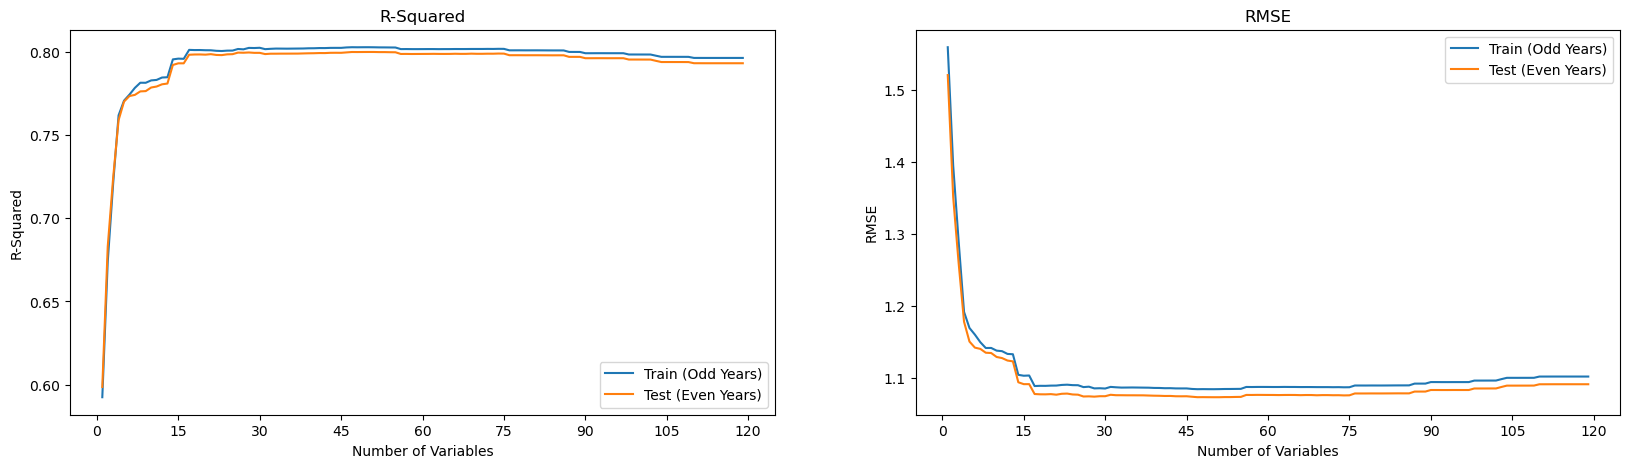

In [21]:
#plot the number of variables against the r-squared and rmse
time_split_prune_df_test_data_even_yrs = time_split_prune_df.copy()

train_years = 'Odd Years'
test_years = 'Even Years'

fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_r2, label = 'Train ({})'.format(train_years))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_r2, label = 'Test ({})'.format(test_years))
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_RMSE, label = 'Train ({})'.format(train_years))
axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_RMSE, label = 'Test ({})'.format(test_years))
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

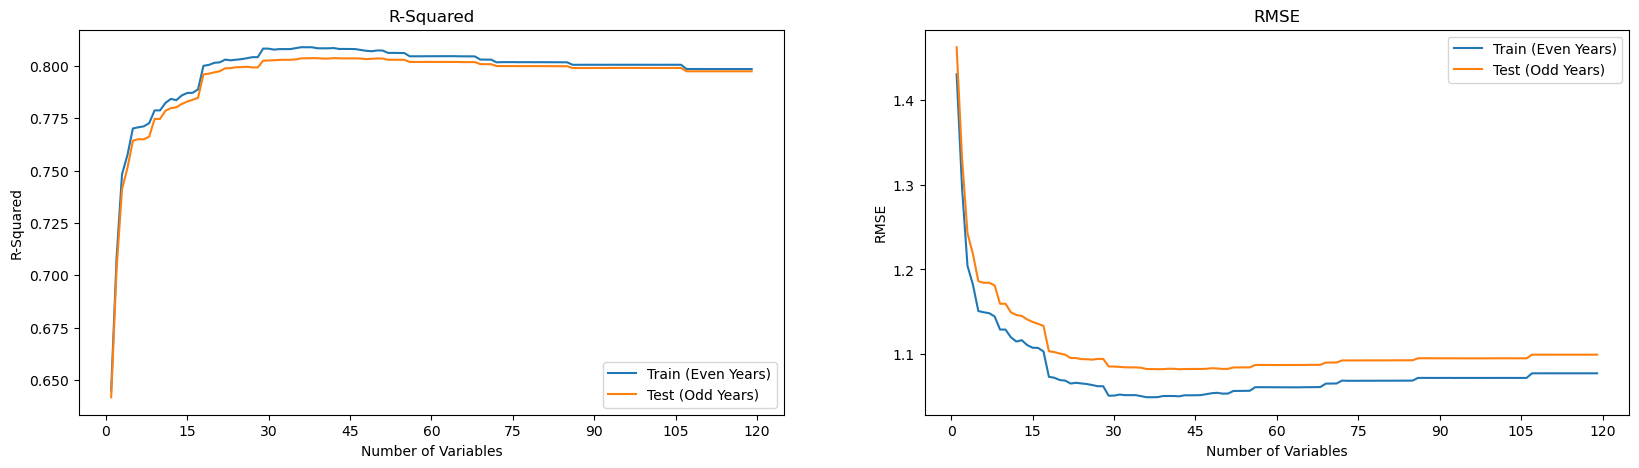

In [19]:
#plot the number of variables against the r-squared and rmse
time_split_prune_df_test_data_odd_yrs = time_split_prune_df.copy()

train_years = 'Even Years'
test_years = 'Odd Years'

fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_r2, label = 'Train ({})'.format(train_years))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_r2, label = 'Test ({})'.format(test_years))
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_RMSE, label = 'Train ({})'.format(train_years))
axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_RMSE, label = 'Test ({})'.format(test_years))
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [169]:
#####################################################
##############PRUNE BASED ON YR SPLITS ##############
#####################################################
#create training and test datasets

#create the datasets
all_yrs = [2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
                 2020]
alt_2_yrs = [2002, 2003, 2006, 2007,  2010, 2011, 2014, 2015,  2018, 2019]


data_alt_2_yrs_2002_start = all_monthly_data_df2[((all_monthly_data_df2['year'].isin(alt_2_yrs)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_alt_2_yrs_2004_start = all_monthly_data_df2[(~(all_monthly_data_df2['year'].isin(alt_2_yrs))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

training_data = data_alt_2_yrs_2002_start
test_data = data_alt_2_yrs_2004_start

#training_data = data_alt_2_yrs_2004_start
#test_data = data_alt_2_yrs_2002_start

#split the data into training and test
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

# get polynomail terms and interactions
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
X_train_poly = X_train_poly.drop('1', axis=1)

X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
X_test_poly = X_test_poly.drop('1', axis=1)


# Create the dataframe to be filled
time_split_prune_df = pd.DataFrame(columns = ['Prune', 'Number_Variables','Train_r2', 'Test_r2', 'Train_RMSE', 'Test_RMSE', 'Alpha', 
                        'Varible_Names'])
prune_num = 0

#start with all the variables
Predictor_Variables_pruned = list(X_train_poly.columns)
#Predictor_Variables_pruned.remove('GRASSLAND WATER') # rm grassland*water- fitting model with this led to poor test perf

while len(Predictor_Variables_pruned) > 0:
    
    #enter the variables which are going into this model
    time_split_prune_df.loc[prune_num, 'Varible_Names'] = list(Predictor_Variables_pruned)
    
    # prune
    X_train_poly = X_train_poly[Predictor_Variables_pruned]
    X_test_poly = X_test_poly[Predictor_Variables_pruned]

    #create normalised datasets
    #the test dataset is normalised using the normalisation parameters from the training data
    scaler = StandardScaler()
    X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
    X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

    X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
    X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

    y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
    y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only
    
    ##########################
    #### RIDGE REGRESSION ####
    ##########################

    folds = 5    #define the number of folds (K)

    #define regression model
    ridge_reg = Ridge(fit_intercept=True)
    #specify the hyperparameters to test
    hyper_params = {'alpha':[0,1,50,90,150, 900,1100, 5000, 20000]}

    hyper_params_0_100 = [0,1e-10,1,10,20,30,40,50,60,70,80,90,100, 130]
    hyper_params_100_1000 = [90,100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,700, 750, 800, 850, 900, 950, 1000]
    hyper_params_1000_10000 = [900,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 100000]
    hyper_params_10000_100000 = [9000,10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 1000000]
    
    #use cross validation to determine the hyperparameter value
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    if chosen_alpha <=100:
        hyper_params_choice = hyper_params_0_100
    elif chosen_alpha <=1000:
        hyper_params_choice = hyper_params_100_1000
    elif chosen_alpha <=10000:
        hyper_params_choice = hyper_params_1000_10000
    elif chosen_alpha <=100000:
        hyper_params_choice = hyper_params_10000_100000
    
    hyper_params = {'alpha':hyper_params_choice}
    #use cross validation to determine the hyperparameter value to higher precision
    model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
    
    #fit the model
    model_cv.fit(X_train_poly_norm, y_train)  
    
    chosen_alpha = list(model_cv.best_params_.values())[0]
    
    RR_model = Ridge(alpha=chosen_alpha)
    RR_model.fit(X_train_poly_norm, y_train)

    d = {'Predictor_Variable': X_train_poly_norm.columns, 'Coefficients': RR_model.coef_}
    coeff_df = pd.DataFrame(data=d)

    coeff_df['Coefficient_Magnitude'] = abs(coeff_df.Coefficients)
    coeff_df = coeff_df.sort_values(by = 'Coefficient_Magnitude', ascending=False).reset_index(drop = True)
    
    # Generate the performance stats
    y_train_pred = RR_model.predict(X_train_poly_norm)
    y_test_pred = RR_model.predict(X_test_poly_norm)

    #####################################################
    ###### Performance Metrics for the training set ######
    ######################################################
    #rmse
    train_ridge_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    #r-square~
    train_ridge_r2 = r2_score(y_train, y_train_pred)
    #mae
    train_ridge_mae = mean_absolute_error(y_train, y_train_pred)

    #################################################
    ###### Performance Metrics for the test set #####
    #################################################
    #rmse
    test_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #r-square
    test_ridge_r2 = r2_score(y_test, y_test_pred)
    #mae
    test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
                            
                            
    # Decide which variables to remove based on their coefficients. Once coefficents are higher, just removed the smallest
    current_num_vars = len(Predictor_Variables_pruned)
    
    
    #start by removing variables with a coefficient of less than 0.05
    min_coefficient = 0.005
       
    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                        
    new_num_vars = len(Predictor_Variables_pruned) 
    
    #if new_num_vars == current_num_vars:
    #    min_coefficient = 0.1
    #    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values
    #    new_num_vars = len(Predictor_Variables_pruned)
    
    #if new_num_vars == current_num_vars:
    #    min_coefficient = 0.2
    #    Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                       
    #    new_num_vars = len(Predictor_Variables_pruned)
    
    if new_num_vars == current_num_vars:                    
        min_coefficient = min(coeff_df.Coefficient_Magnitude)
        Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > min_coefficient].Predictor_Variable.values                    
        new_num_vars = len(Predictor_Variables_pruned)
    
    #add the results to the dataframe 
    time_split_prune_df.loc[prune_num, 'Prune'] = prune_num
    time_split_prune_df.loc[prune_num, 'Number_Variables'] = current_num_vars                       
    time_split_prune_df.loc[prune_num, 'Train_r2'] = train_ridge_r2                       
    time_split_prune_df.loc[prune_num, 'Test_r2'] = test_ridge_r2
    time_split_prune_df.loc[prune_num, 'Train_RMSE'] = train_ridge_rmse
    time_split_prune_df.loc[prune_num, 'Test_RMSE'] = test_ridge_rmse
    time_split_prune_df.loc[prune_num, 'Alpha'] = chosen_alpha
                         
    #add to the prune count
    prune_num = prune_num + 1                        
    
time_split_prune_df['Train_r2'] = time_split_prune_df['Train_r2'].apply(lambda x: float(x))
time_split_prune_df['Test_r2'] = time_split_prune_df['Test_r2'].apply(lambda x: float(x))
time_split_prune_df['Train_RMSE'] = time_split_prune_df['Train_RMSE'].apply(lambda x: float(x))
time_split_prune_df['Test_RMSE'] = time_split_prune_df['Test_RMSE'].apply(lambda x: float(x))
time_split_prune_df['Alpha'] = time_split_prune_df['Alpha'].apply(lambda x: float(x))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.25807e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.35218e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.27621e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=9.62058e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.51077e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.54794e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.22238e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each

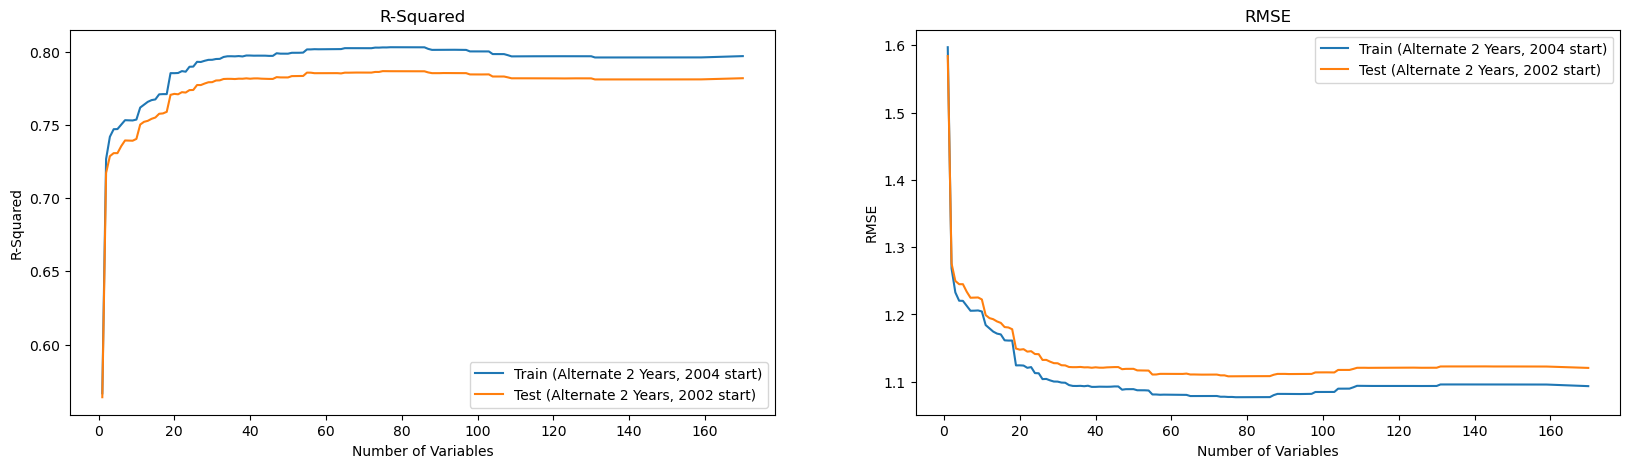

In [168]:
#plot the number of variables against the r-squared and rmse
time_split_prune_df_test_data_alt_2_years_2002_start = time_split_prune_df.copy()

train_years = 'Alternate 2 Years, 2004 start'
test_years = 'Alternate 2 Years, 2002 start'

fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_r2, label = 'Train ({})'.format(train_years))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_r2, label = 'Test ({})'.format(test_years))
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_RMSE, label = 'Train ({})'.format(train_years))
axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_RMSE, label = 'Test ({})'.format(test_years))
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

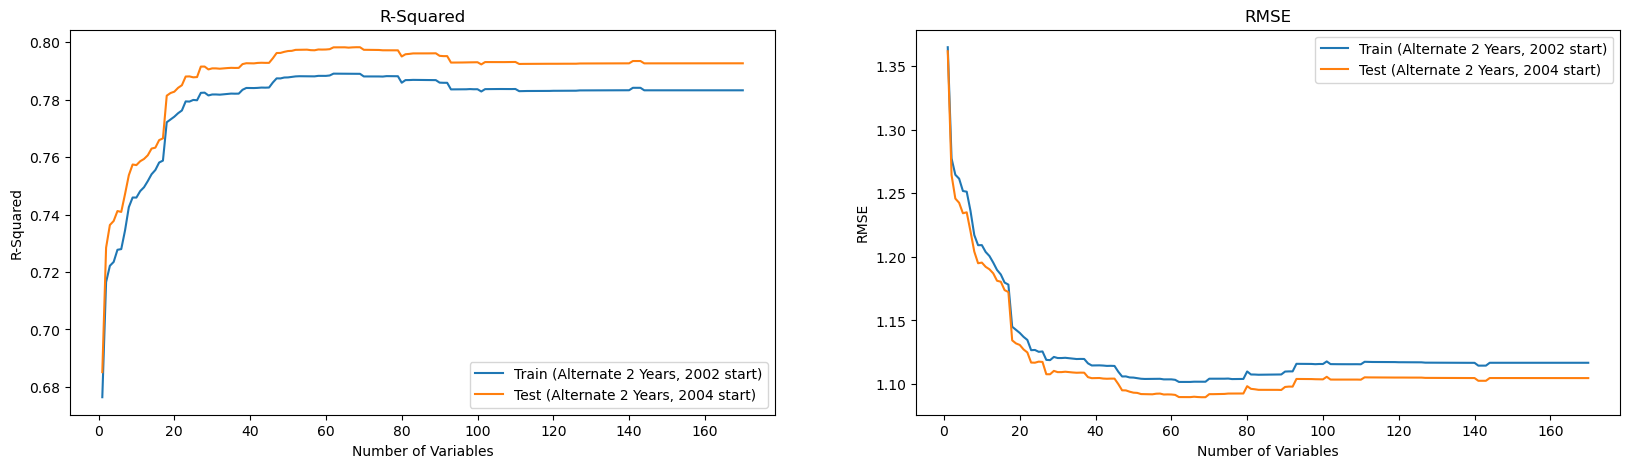

In [170]:
#plot the number of variables against the r-squared and rmse
time_split_prune_df_test_data_alt_2_years_2004_start = time_split_prune_df.copy()

train_years = 'Alternate 2 Years, 2002 start'
test_years = 'Alternate 2 Years, 2004 start'

fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_r2, label = 'Train ({})'.format(train_years))
axes[0].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_r2, label = 'Test ({})'.format(test_years))
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Train_RMSE, label = 'Train ({})'.format(train_years))
axes[1].plot(time_split_prune_df.Number_Variables, time_split_prune_df.Test_RMSE, label = 'Test ({})'.format(test_years))
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [119]:
################################################
########## VARIABLE EVOLUTION BY CITY ##########
################################################

######## MAKE SURE THE RIDGE REGRESSION MODEL HAS BEEN FIT BEFORE RUNNING THIS ##############################
plt.rc('legend', fontsize=10)    # legend fontsize
#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values

overpass_file_name = '1330'
for i, city in enumerate(cities):
    data_city = all_monthly_data_df[((all_monthly_data_df['City'] == city) 
                                    & (all_monthly_data_df['Overpass'] == overpass_time))].copy()

    SUHI_MEAN = list(data_city.groupby(['year']).mean(numeric_only = True).SUHI_MEAN)
    SUHI_MEAN_STD = list(data_city.groupby(['year']).std(numeric_only = True).SUHI_MEAN)
        
    EF = list(data_city.groupby(['year']).mean(numeric_only = True).EF)
    EF_STD = list(data_city.groupby(['year']).std(numeric_only = True).EF)     
    
    SSR = list(data_city.groupby(['year']).mean(numeric_only = True).SSR)
    SSR_STD = list(data_city.groupby(['year']).std(numeric_only = True).SSR)
    
    EVI_U = list(data_city.groupby(['year']).mean(numeric_only = True).EVI_U)
    EVI_U_STD = list(data_city.groupby(['year']).std(numeric_only = True).EVI_U)
    
    EVI_R = list(data_city.groupby(['year']).mean(numeric_only = True).EVI_R)
    EVI_R_STD = list(data_city.groupby(['year']).std(numeric_only = True).EVI_R)
    
    EVI_D = list(data_city.groupby(['year']).mean(numeric_only = True).EVI_D)
    EVI_D_STD = list(data_city.groupby(['year']).std(numeric_only = True).EVI_D)
    
    ECC = list(data_city.groupby(['year']).mean(numeric_only = True).ECC)
    ECC_STD = list(data_city.groupby(['year']).std(numeric_only = True).ECC)
    
    LOG_AREA = list(data_city.groupby(['year']).mean(numeric_only = True).LOG_AREA)
    LOG_AREA_STD = list(data_city.groupby(['year']).std(numeric_only = True).LOG_AREA)
    
    CROPLAND = list(data_city.groupby(['year']).mean(numeric_only = True).CROPLAND)
    CROPLAND_STD = list(data_city.groupby(['year']).std(numeric_only = True).CROPLAND)
    
    GRASSLAND = list(data_city.groupby(['year']).mean(numeric_only = True).GRASSLAND)
    GRASSLAND_STD = list(data_city.groupby(['year']).std(numeric_only = True).GRASSLAND)
    
    WATER = list(data_city.groupby(['year']).mean(numeric_only = True).WATER)
    WATER_STD = list(data_city.groupby(['year']).std(numeric_only = True).WATER)
    
    BARE = list(data_city.groupby(['year']).mean(numeric_only = True).BARE)
    BARE_STD = list(data_city.groupby(['year']).std(numeric_only = True).BARE)    
        
    #check for/ insert missing months as nans
    yrs = list(set(data_city.year))
    
    all_yrs = [2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
                 2020]
    if len(SUHI_MEAN) != 19:
        # find which is the missing month and add it into the df with nan values
        missing_yr = [i for i in all_months if i not in mons]
        SUHI_MEAN.insert(missing_month[0],np.nan)
        SUHI_MEAN_STD.insert(missing_month[0],np.nan)
        
        EF.insert(missing_month[0],np.nan)
        EF_STD.insert(missing_month[0],np.nan)
        SSR.insert(missing_month[0],np.nan)
        SSR_STD.insert(missing_month[0],np.nan)
        EVI_U.insert(missing_month[0],np.nan)
        EVI_U_STD.insert(missing_month[0],np.nan)
        EVI_R.insert(missing_month[0],np.nan)
        EVI_R_STD.insert(missing_month[0],np.nan)
        EVI_D.insert(missing_month[0],np.nan)
        EVI_D_STD.insert(missing_month[0],np.nan)
        ECC.insert(missing_month[0],np.nan)
        ECC_STD.insert(missing_month[0],np.nan)
        LOG_AREA.insert(missing_month[0],np.nan)
        LOG_AREA_STD.insert(missing_month[0],np.nan)
        CROPLAND.insert(missing_month[0],np.nan)
        CROPLAND_STD.insert(missing_month[0],np.nan)
        GRASSLAND.insert(missing_month[0],np.nan)
        GRASSLAND_STD.insert(missing_month[0],np.nan)
        WATER.insert(missing_month[0],np.nan)
        WATER_STD.insert(missing_month[0],np.nan)
        BARE.insert(missing_month[0],np.nan)
        BARE_STD.insert(missing_month[0],np.nan)
        
    fig, axes = plt.subplots(nrows = 4,ncols = 3, figsize=(25, 30))
 
    #MEAN_SUHI
    xi, yi = 0,0
    axes[xi, yi].errorbar(x = all_yrs, y = SUHI_MEAN, yerr = SUHI_MEAN_STD)
    axes[xi, yi].set_title('{} SUHI Mean Magnitude {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'SUHI Mean Magnitude (K)')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'EF'
    xi, yi = 0,1
    axes[xi, yi].errorbar(x = all_yrs, y = EF, yerr = EF_STD)
    axes[xi, yi].set_title('{} Evaporative Fraction {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Evaporative Fraction')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'SSR'
    xi, yi = 0,2
    axes[xi, yi].errorbar(x = all_yrs, y = SSR, yerr = SSR_STD)
    axes[xi, yi].set_title('{} Net Surface Solar Radiation {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Net Surface Solar Radiation (W$m^-2$)')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'EVI_U'
    xi, yi = 1,0
    axes[xi, yi].errorbar(x = all_yrs, y = EVI_U, yerr = EVI_U_STD)
    axes[xi, yi].set_title('{} Urban EVI {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'EVI')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'EVI_R'
    xi, yi = 1,1
    axes[xi, yi].errorbar(x = all_yrs, y = EVI_R, yerr = EVI_R_STD)
    axes[xi, yi].set_title('{} Rural EVI {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'EVI')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'EVI_D'
    xi, yi = 1,2
    axes[xi, yi].errorbar(x = all_yrs, y = EVI_D, yerr = EVI_D_STD)
    axes[xi, yi].set_title('{} EVI Difference (Urban-Rural) {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'EVI Difference')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'ECC'
    xi, yi = 2,0
    axes[xi, yi].errorbar(x = all_yrs, y = ECC, yerr = ECC_STD)
    axes[xi, yi].set_title('{} Eccentricity {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Eccentricity')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'LOG_AREA'
    xi, yi = 2,1
    axes[xi, yi].errorbar(x = all_yrs, y = LOG_AREA, yerr = LOG_AREA_STD)
    axes[xi, yi].set_title('{} Log (Base 10) of City Area {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Log Area ($km^2$)')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'CROPLAND'   
    xi, yi = 2,2
    axes[xi, yi].errorbar(x = all_yrs, y = CROPLAND, yerr = CROPLAND_STD)
    axes[xi, yi].set_title('{} Percentage of Cropland {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Percentage of Total Area')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'GRASSLAND'
    xi, yi = 3,0
    axes[xi, yi].errorbar(x = all_yrs, y = GRASSLAND, yerr = GRASSLAND_STD)
    axes[xi, yi].set_title('{} Percentage of Grassland {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Percentage of Total Area')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'WATER'
    xi, yi = 3,1
    axes[xi, yi].errorbar(x = all_yrs, y = WATER, yerr = WATER_STD)
    axes[xi, yi].set_title('{} Percentage of Water {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Percentage of Total Area')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    #'BARE' 
    xi, yi = 3,2
    axes[xi, yi].errorbar(x = all_yrs, y = BARE, yerr = BARE_STD)
    axes[xi, yi].set_title('{} Percentage of Bare land {}'.format(city,overpass_time))
    axes[xi, yi].set(xlabel = 'Year', ylabel = 'Percentage of Total Area')
    axes[xi, yi].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    #save figure as png
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','all_variables'))   
    plt.savefig('{}_{}_MEAN_SUHI.png'.format(overpass_file_name, city), bbox_inches = 'tight')

    plt.close()        


In [110]:
data_city

,year,month,SUHI_PEAK_GSA,SUHI_MEAN,SUHI_PEAK_QUANTILE,SUHI_FP,EF,RH,TP,T2M,...,sqrt_EF,sqrt_RH,sqrt_TP,sqrt_T2M,sqrt_SSR,sqrt_EVI_R_p1,sqrt_EVI_U_p1,sqrt_EVI_D_p1,CROPLAND,ELEVATION_D
0,2002,7,-2.428468,-1.461481,-1.182500,149.267847,0.451737,32.659958,3.868342e-06,291.976410,...,0.672114,5.714889,0.001967,17.087317,14.210833,1.079654,1.084630,1.005371,15.789474,24.251064
1,2002,8,-2.160043,-1.388989,-1.200000,69.111796,0.396872,35.970322,2.145316e-04,293.212769,...,0.629978,5.997526,0.014647,17.123457,14.410502,1.075433,1.073951,0.998405,15.789474,24.251064
2,2002,9,1.638151,-0.144017,1.250000,429.201804,0.416079,38.924397,6.511558e-04,294.594177,...,0.645042,6.238942,0.025518,17.163746,14.900113,1.098533,1.080055,0.979665,15.789474,24.251064
3,2002,10,6.728467,1.661348,4.003333,219.252606,0.716956,75.767159,6.286502e-03,292.602539,...,0.846732,8.704433,0.079287,17.105629,14.911221,1.099011,1.093846,0.994321,15.789474,24.251064
4,2002,11,3.847056,2.213450,4.130000,361.805099,0.730378,81.533249,7.264750e-03,292.097290,...,0.854622,9.029576,0.085234,17.090854,14.293019,1.130214,1.099392,0.965029,15.789474,24.251064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2020,7,-1.176155,-0.682004,-0.900000,158.371675,0.402631,33.369556,4.395843e-07,289.208069,...,0.634532,5.776639,0.000663,17.006119,14.472543,1.089616,1.068002,0.976405,14.536341,24.251064
188,2020,8,-1.974544,-0.742548,-0.680000,158.163184,0.398155,32.546806,2.787784e-05,292.937439,...,0.630995,5.704981,0.005280,17.115415,14.614894,1.082478,1.065153,0.981219,14.536341,24.251064
189,2020,9,2.732108,0.135017,0.390000,302.545761,0.400091,36.543022,3.122777e-04,294.970093,...,0.632527,6.045082,0.017671,17.174693,15.298123,1.092828,1.071798,0.976973,14.536341,24.251064
190,2020,10,4.900307,1.693415,3.010000,213.892903,0.590793,57.485634,3.336456e-03,294.813751,...,0.768630,7.581928,0.057762,17.170141,15.426002,1.107700,NaN,NaN,14.536341,24.251064


(<Figure size 2500x3000 with 12 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], dtype=object))

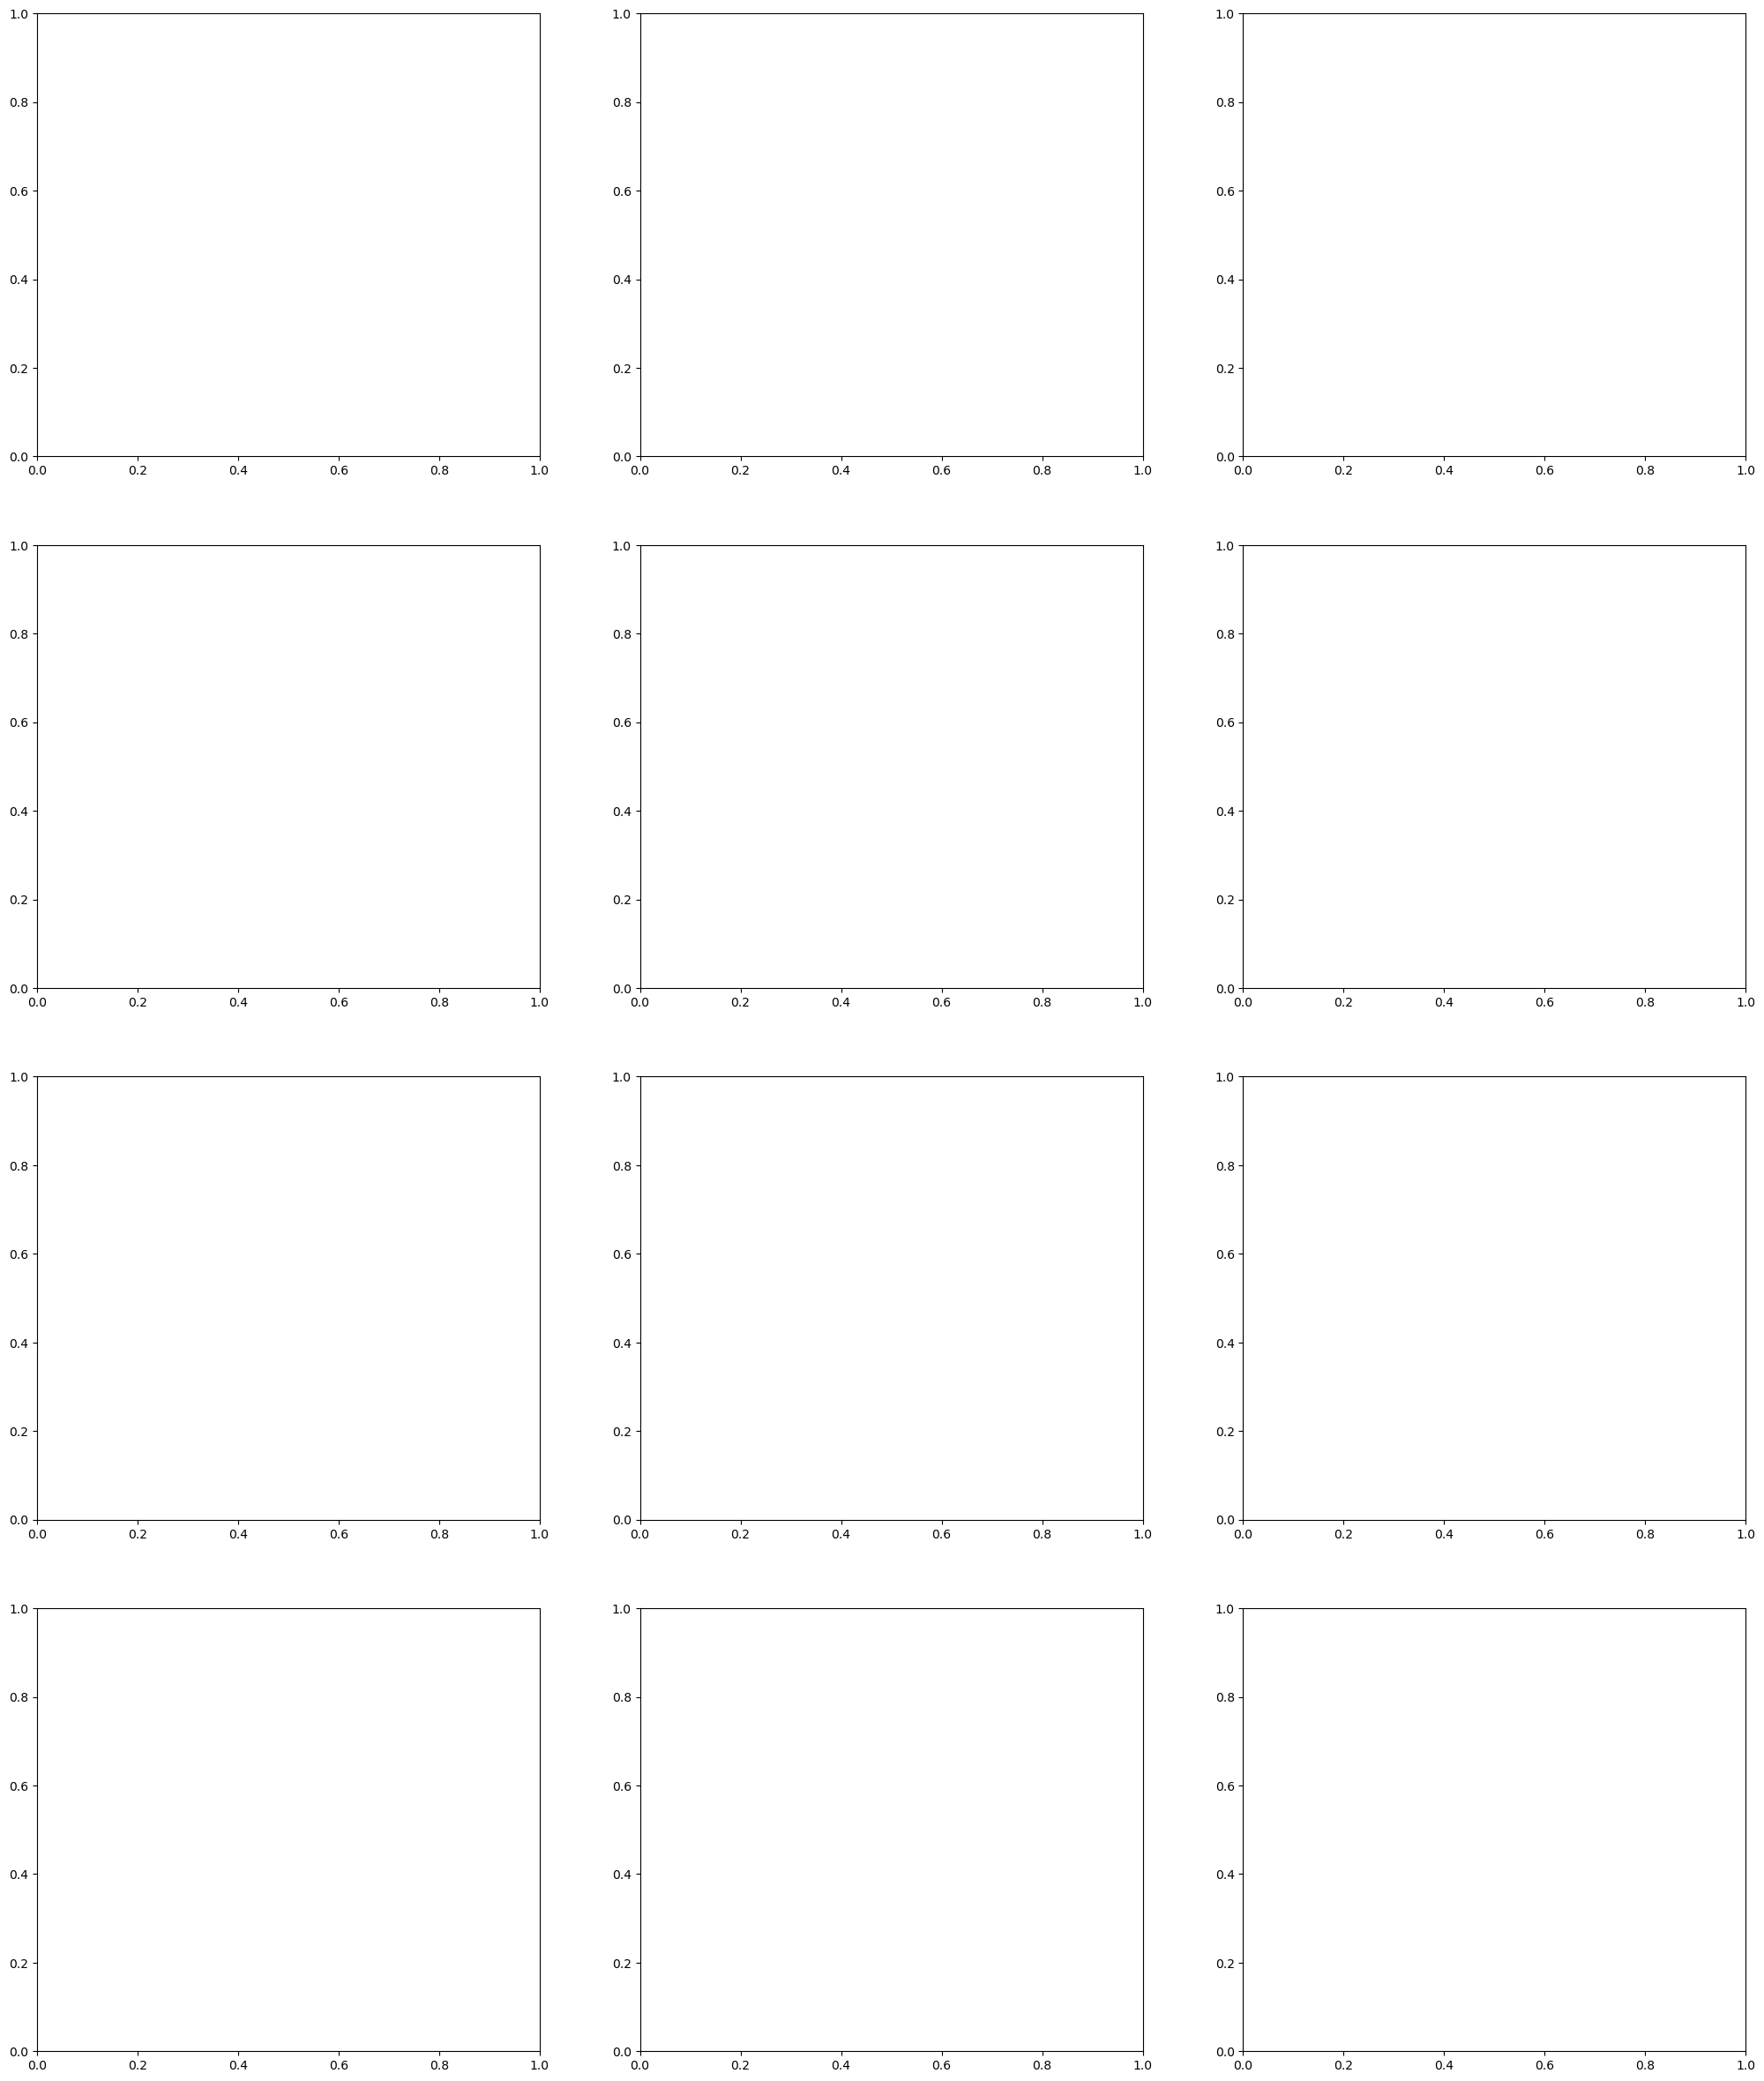

In [117]:
plt.subplots(nrows = 4,ncols = 3, figsize=(25, 30))